In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 5
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 20
n_seq (number of output/future prediction time steps): 5
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     8000

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

5
20
(19, 225)
(2, 225)


[I 2025-06-06 23:08:26,293] A new study created in memory with name: no-name-ac31bf9f-0251-4307-9094-8ccaec1af4e3
[I 2025-06-06 23:10:58,970] Trial 0 finished with value: 0.08064764142036437 and parameters: {'lr': 0.00719052117026894, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10721426727510304}. Best is trial 0 with value: 0.08064764142036437.


Cross Validation Accuracies:
[0.0680851861834526, 0.09605994820594788, 0.08045855164527893, 0.09250005334615707, 0.06613446772098541]
Mean Cross Validation Accuracy:
0.08064764142036437
Standard Deviation of Cross Validation Accuracy:
0.012218855234942552


[I 2025-06-06 23:13:33,517] Trial 1 finished with value: 0.07687433138489723 and parameters: {'lr': 0.013863413851532532, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14628839921404554}. Best is trial 1 with value: 0.07687433138489723.


Cross Validation Accuracies:
[0.059073466807603836, 0.09755486249923706, 0.07518693804740906, 0.09422362595796585, 0.058332763612270355]
Mean Cross Validation Accuracy:
0.07687433138489723
Standard Deviation of Cross Validation Accuracy:
0.01668646278152287


[I 2025-06-06 23:16:22,316] Trial 2 finished with value: 0.07629359066486359 and parameters: {'lr': 0.003351699232334642, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.139223353452408}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[0.06018764525651932, 0.09709467738866806, 0.07253235578536987, 0.09435331076383591, 0.057299964129924774]
Mean Cross Validation Accuracy:
0.07629359066486359
Standard Deviation of Cross Validation Accuracy:
0.01669218327965804


[I 2025-06-06 23:19:27,290] Trial 3 finished with value: 0.08641837537288666 and parameters: {'lr': 0.05968141106198966, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.18239798900261586}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[0.08729804307222366, 0.09898363053798676, 0.0705878883600235, 0.10379356145858765, 0.07142875343561172]
Mean Cross Validation Accuracy:
0.08641837537288666
Standard Deviation of Cross Validation Accuracy:
0.01368100602313245


[I 2025-06-06 23:22:46,112] Trial 4 finished with value: 1.5373775243759156 and parameters: {'lr': 0.01959990450241407, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3157027712891976}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[1.9195655584335327, 1.7331907749176025, 1.6653705835342407, 1.6855727434158325, 0.6831879615783691]
Mean Cross Validation Accuracy:
1.5373775243759156
Standard Deviation of Cross Validation Accuracy:
0.4364388566101297


[I 2025-06-06 23:25:28,613] Trial 5 finished with value: 2.297348737716675 and parameters: {'lr': 0.5793707400111412, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.21495557060986625}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[3.7828893661499023, 1.8422106504440308, 2.6449265480041504, 1.8320261240005493, 1.3846909999847412]
Mean Cross Validation Accuracy:
2.297348737716675
Standard Deviation of Cross Validation Accuracy:
0.8466712765287132


[I 2025-06-06 23:29:15,117] Trial 6 finished with value: 86.69273529052734 and parameters: {'lr': 0.795101486592369, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.27040785878736}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[78.93449401855469, 90.41828918457031, 89.96255493164062, 90.84188079833984, 83.30645751953125]
Mean Cross Validation Accuracy:
86.69273529052734
Standard Deviation of Cross Validation Accuracy:
4.763277559082858


[I 2025-06-06 23:31:56,302] Trial 7 finished with value: 1.2538942098617554 and parameters: {'lr': 0.24155994811395748, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.30680858303593206}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[1.3676047325134277, 0.9253131151199341, 1.6332709789276123, 1.1386635303497314, 1.2046186923980713]
Mean Cross Validation Accuracy:
1.2538942098617554
Standard Deviation of Cross Validation Accuracy:
0.23686643401394608


[I 2025-06-06 23:35:42,346] Trial 8 finished with value: 2.239780640602112 and parameters: {'lr': 0.4920019626901586, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3734040581327923}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[2.038857936859131, 2.735659122467041, 1.3567907810211182, 1.5436290502548218, 3.5239663124084473]
Mean Cross Validation Accuracy:
2.239780640602112
Standard Deviation of Cross Validation Accuracy:
0.7999620453739877


[I 2025-06-06 23:39:02,942] Trial 9 finished with value: 0.10435344129800797 and parameters: {'lr': 0.008817947745201643, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11474785517904094}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[0.06284903734922409, 0.10066326707601547, 0.07684013992547989, 0.20433898270130157, 0.0770757794380188]
Mean Cross Validation Accuracy:
0.10435344129800797
Standard Deviation of Cross Validation Accuracy:
0.051447826021330946


[I 2025-06-06 23:42:10,856] Trial 10 finished with value: 0.09244005754590034 and parameters: {'lr': 0.001143646390085898, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.47510284298388294}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[0.05811634659767151, 0.18382544815540314, 0.07164277881383896, 0.09144967794418335, 0.05716603621840477]
Mean Cross Validation Accuracy:
0.09244005754590034
Standard Deviation of Cross Validation Accuracy:
0.04734378731182398


[I 2025-06-06 23:45:03,352] Trial 11 finished with value: 0.09465669393539429 and parameters: {'lr': 0.0015566796064278112, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18829788014511084}. Best is trial 2 with value: 0.07629359066486359.


Cross Validation Accuracies:
[0.05985439568758011, 0.09693609178066254, 0.07214704900979996, 0.0940098762512207, 0.15033605694770813]
Mean Cross Validation Accuracy:
0.09465669393539429
Standard Deviation of Cross Validation Accuracy:
0.031060230427724583


[I 2025-06-06 23:47:15,704] Trial 12 finished with value: 0.0760985903441906 and parameters: {'lr': 0.003796454462374501, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14925278209874768}. Best is trial 12 with value: 0.0760985903441906.


Cross Validation Accuracies:
[0.058767084032297134, 0.0971807986497879, 0.07239032536745071, 0.09440762549638748, 0.057747118175029755]
Mean Cross Validation Accuracy:
0.0760985903441906
Standard Deviation of Cross Validation Accuracy:
0.016915017861045142


[I 2025-06-06 23:49:50,759] Trial 13 finished with value: 0.07631169855594636 and parameters: {'lr': 0.0028783846154588765, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24653174632761643}. Best is trial 12 with value: 0.0760985903441906.


Cross Validation Accuracies:
[0.059171613305807114, 0.09728967398405075, 0.07261621952056885, 0.09483729302883148, 0.057643692940473557]
Mean Cross Validation Accuracy:
0.07631169855594636
Standard Deviation of Cross Validation Accuracy:
0.01696588709722084


[I 2025-06-06 23:52:44,301] Trial 14 finished with value: 0.1980106472969055 and parameters: {'lr': 0.059438209790941096, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16490694110268794}. Best is trial 12 with value: 0.0760985903441906.


Cross Validation Accuracies:
[0.24007633328437805, 0.24194808304309845, 0.16922172904014587, 0.18077944219112396, 0.15802764892578125]
Mean Cross Validation Accuracy:
0.1980106472969055
Standard Deviation of Cross Validation Accuracy:
0.035845157553244765


[I 2025-06-06 23:56:12,179] Trial 15 finished with value: 0.07657339572906494 and parameters: {'lr': 0.0040043990235619446, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3688110281052225}. Best is trial 12 with value: 0.0760985903441906.


Cross Validation Accuracies:
[0.05978771299123764, 0.09743856638669968, 0.0723889172077179, 0.0947151854634285, 0.058536596596241]
Mean Cross Validation Accuracy:
0.07657339572906494
Standard Deviation of Cross Validation Accuracy:
0.016667783354522746


[I 2025-06-06 23:58:41,846] Trial 16 finished with value: 0.0762109749019146 and parameters: {'lr': 0.0032306828417959753, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23250124658678473}. Best is trial 12 with value: 0.0760985903441906.


Cross Validation Accuracies:
[0.059941865503787994, 0.09704544395208359, 0.07267113029956818, 0.09413022547960281, 0.05726620927453041]
Mean Cross Validation Accuracy:
0.0762109749019146
Standard Deviation of Cross Validation Accuracy:
0.016681086337297812


[I 2025-06-07 00:01:22,995] Trial 17 finished with value: 0.07595848590135575 and parameters: {'lr': 0.04025183122584699, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.23238936319230924}. Best is trial 17 with value: 0.07595848590135575.


Cross Validation Accuracies:
[0.053016986697912216, 0.09893105924129486, 0.07443960011005402, 0.09778115153312683, 0.05562363192439079]
Mean Cross Validation Accuracy:
0.07595848590135575
Standard Deviation of Cross Validation Accuracy:
0.019728626648340578


[I 2025-06-07 00:04:06,959] Trial 18 finished with value: 0.07504998221993446 and parameters: {'lr': 0.05185328658239616, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.37027517965373125}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.05817533656954765, 0.09526965022087097, 0.07053504139184952, 0.08503315597772598, 0.06623672693967819]
Mean Cross Validation Accuracy:
0.07504998221993446
Standard Deviation of Cross Validation Accuracy:
0.013351483494267931


[I 2025-06-07 00:07:04,770] Trial 19 finished with value: 0.08108296170830727 and parameters: {'lr': 0.1650476140039921, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.46047613635127904}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.056021858006715775, 0.09977768361568451, 0.0818227231502533, 0.10095827281475067, 0.06683427095413208]
Mean Cross Validation Accuracy:
0.08108296170830727
Standard Deviation of Cross Validation Accuracy:
0.017754728793834693


[I 2025-06-07 00:10:05,538] Trial 20 finished with value: 0.08099517449736596 and parameters: {'lr': 0.05238649609943927, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.41309690998599224}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.07304354757070541, 0.09910737723112106, 0.0728091225028038, 0.09973461925983429, 0.06028120592236519]
Mean Cross Validation Accuracy:
0.08099517449736596
Standard Deviation of Cross Validation Accuracy:
0.015738659345947068


[I 2025-06-07 00:12:58,781] Trial 21 finished with value: 0.07995548248291015 and parameters: {'lr': 0.03010450879230081, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.34659621090877357}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.06283199042081833, 0.10692393779754639, 0.07587315887212753, 0.09978179633617401, 0.05436652898788452]
Mean Cross Validation Accuracy:
0.07995548248291015
Standard Deviation of Cross Validation Accuracy:
0.020420843226957662


[I 2025-06-07 00:15:42,782] Trial 22 finished with value: 0.08719603717327118 and parameters: {'lr': 0.09290576871559258, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.41774145383245015}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.06577536463737488, 0.10381917655467987, 0.0941026583313942, 0.0981350913643837, 0.07414789497852325]
Mean Cross Validation Accuracy:
0.08719603717327118
Standard Deviation of Cross Validation Accuracy:
0.014647814252892018


[I 2025-06-07 00:19:05,869] Trial 23 finished with value: 0.07799498587846757 and parameters: {'lr': 0.027144567693078884, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2724254481258233}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.061238259077072144, 0.09559857100248337, 0.07049966603517532, 0.09830906242132187, 0.0643293708562851]
Mean Cross Validation Accuracy:
0.07799498587846757
Standard Deviation of Cross Validation Accuracy:
0.015787746271027837


[I 2025-06-07 00:21:43,875] Trial 24 finished with value: 0.07796062454581261 and parameters: {'lr': 0.10127504215634603, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21256096989273354}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.048300087451934814, 0.10473936796188354, 0.07759404927492142, 0.10176286846399307, 0.057406749576330185]
Mean Cross Validation Accuracy:
0.07796062454581261
Standard Deviation of Cross Validation Accuracy:
0.022741994322714825


[I 2025-06-07 00:24:26,252] Trial 25 finished with value: 0.07680272683501244 and parameters: {'lr': 0.010773010164077305, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2671170848982227}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.06182869151234627, 0.09781722724437714, 0.07248743623495102, 0.09567990154027939, 0.05620037764310837]
Mean Cross Validation Accuracy:
0.07680272683501244
Standard Deviation of Cross Validation Accuracy:
0.017118745347372524


[I 2025-06-07 00:27:06,816] Trial 26 finished with value: 0.07670164629817008 and parameters: {'lr': 0.017843067877884453, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3363011544252953}. Best is trial 18 with value: 0.07504998221993446.


Cross Validation Accuracies:
[0.054159682244062424, 0.10057753324508667, 0.07403119653463364, 0.09835581481456757, 0.05638400465250015]
Mean Cross Validation Accuracy:
0.07670164629817008
Standard Deviation of Cross Validation Accuracy:
0.019834510324364434


[I 2025-06-07 00:29:45,810] Trial 27 finished with value: 0.07440866902470589 and parameters: {'lr': 0.23784980743911982, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40883350723944606}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05608188360929489, 0.09576019644737244, 0.07985714823007584, 0.08116605877876282, 0.05917805805802345]
Mean Cross Validation Accuracy:
0.07440866902470589
Standard Deviation of Cross Validation Accuracy:
0.01482618318584667


[I 2025-06-07 00:33:25,583] Trial 28 finished with value: 0.07823777347803115 and parameters: {'lr': 0.28953767268473385, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.41314431597555}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06005855277180672, 0.10822499543428421, 0.07064653187990189, 0.09384862333536148, 0.0584101639688015]
Mean Cross Validation Accuracy:
0.07823777347803115
Standard Deviation of Cross Validation Accuracy:
0.019617223184023664


[I 2025-06-07 00:37:03,697] Trial 29 finished with value: 0.11133503317832946 and parameters: {'lr': 0.1424147537274312, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4470765163474916}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.11649689078330994, 0.12418679147958755, 0.1304454654455185, 0.11464858055114746, 0.07089743763208389]
Mean Cross Validation Accuracy:
0.11133503317832946
Standard Deviation of Cross Validation Accuracy:
0.02099142594756497


[I 2025-06-07 00:39:59,812] Trial 30 finished with value: 0.07643896266818047 and parameters: {'lr': 0.044903493476532386, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3716462903724757}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05840614065527916, 0.09698527306318283, 0.07170470803976059, 0.09665706008672714, 0.058441631495952606]
Mean Cross Validation Accuracy:
0.07643896266818047
Standard Deviation of Cross Validation Accuracy:
0.017334486436189355


[I 2025-06-07 00:42:53,720] Trial 31 finished with value: 0.10449507236480712 and parameters: {'lr': 0.005949850534154777, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11215505830008679}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.060970887541770935, 0.1431482434272766, 0.11324836313724518, 0.1414562463760376, 0.06365162134170532]
Mean Cross Validation Accuracy:
0.10449507236480712
Standard Deviation of Cross Validation Accuracy:
0.03605373287970655


[I 2025-06-07 00:45:41,703] Trial 32 finished with value: 0.08190893977880478 and parameters: {'lr': 0.3367623110359658, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4310729006619155}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05645766109228134, 0.10619579255580902, 0.07948087900876999, 0.11562605947256088, 0.05178430676460266]
Mean Cross Validation Accuracy:
0.08190893977880478
Standard Deviation of Cross Validation Accuracy:
0.02564313537139082


[I 2025-06-07 00:48:21,813] Trial 33 finished with value: 0.07868215665221215 and parameters: {'lr': 0.11392083813416676, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40026405854280495}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06511696428060532, 0.09611937403678894, 0.07737088203430176, 0.09530863165855408, 0.05949493125081062]
Mean Cross Validation Accuracy:
0.07868215665221215
Standard Deviation of Cross Validation Accuracy:
0.015062401701322165


[I 2025-06-07 00:51:41,823] Trial 34 finished with value: 0.1649279475212097 and parameters: {'lr': 0.03995117194347019, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15044216258467538}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.15725289285182953, 0.1576819121837616, 0.1610153466463089, 0.18767999112606049, 0.16100959479808807]
Mean Cross Validation Accuracy:
0.1649279475212097
Standard Deviation of Cross Validation Accuracy:
0.011486765551325768


[I 2025-06-07 00:54:20,443] Trial 35 finished with value: 0.08036157414317131 and parameters: {'lr': 0.015209356181986827, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.48606070366934095}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06991124898195267, 0.1086941659450531, 0.06099073216319084, 0.10952045023441315, 0.052691273391246796]
Mean Cross Validation Accuracy:
0.08036157414317131
Standard Deviation of Cross Validation Accuracy:
0.024095892479038754


[I 2025-06-07 00:57:04,497] Trial 36 finished with value: 0.07591503411531449 and parameters: {'lr': 0.07480074533563306, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.29048884938933933}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05606760457158089, 0.09837709367275238, 0.07311172038316727, 0.0928976833820343, 0.05912106856703758]
Mean Cross Validation Accuracy:
0.07591503411531449
Standard Deviation of Cross Validation Accuracy:
0.017185870951972916


[I 2025-06-07 01:00:15,028] Trial 37 finished with value: 0.07853689342737198 and parameters: {'lr': 0.07002335860256491, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2887095883009577}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06329994648694992, 0.09902544319629669, 0.06791769713163376, 0.09266456216573715, 0.06977681815624237]
Mean Cross Validation Accuracy:
0.07853689342737198
Standard Deviation of Cross Validation Accuracy:
0.014429431703315272


[I 2025-06-07 01:03:03,146] Trial 38 finished with value: 0.08028633892536163 and parameters: {'lr': 0.19256285921307578, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3320232165822509}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06699643284082413, 0.10113335400819778, 0.06422263383865356, 0.10549066960811615, 0.06358860433101654]
Mean Cross Validation Accuracy:
0.08028633892536163
Standard Deviation of Cross Validation Accuracy:
0.018885628866740896


[I 2025-06-07 01:06:03,869] Trial 39 finished with value: 0.0996996283531189 and parameters: {'lr': 0.025240580071251413, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3045615247802381}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.0532214380800724, 0.0991540178656578, 0.15709897875785828, 0.12919074296951294, 0.05983296409249306]
Mean Cross Validation Accuracy:
0.0996996283531189
Standard Deviation of Cross Validation Accuracy:
0.03978512799862367


[I 2025-06-07 01:10:26,994] Trial 40 finished with value: 6.8982902526855465 and parameters: {'lr': 0.0743600568776011, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3535452032398876}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[6.405585289001465, 8.478775024414062, 5.21942663192749, 6.0317254066467285, 8.355938911437988]
Mean Cross Validation Accuracy:
6.8982902526855465
Standard Deviation of Cross Validation Accuracy:
1.298841606722128


[I 2025-06-07 01:13:29,756] Trial 41 finished with value: 0.10630680918693543 and parameters: {'lr': 0.9714360819563612, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.210445307555601}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.1065475344657898, 0.13244900107383728, 0.11046148091554642, 0.09424587339162827, 0.08783015608787537]
Mean Cross Validation Accuracy:
0.10630680918693543
Standard Deviation of Cross Validation Accuracy:
0.015411595144471732


[I 2025-06-07 01:16:06,058] Trial 42 finished with value: 0.08000094965100288 and parameters: {'lr': 0.041884065362134716, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3887865495379338}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.0631445124745369, 0.101234570145607, 0.08306603133678436, 0.09074205905199051, 0.06181757524609566]
Mean Cross Validation Accuracy:
0.08000094965100288
Standard Deviation of Cross Validation Accuracy:
0.015429889016104746


[I 2025-06-07 01:18:53,842] Trial 43 finished with value: 0.09872862547636033 and parameters: {'lr': 0.36480240995691954, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.32085326002468567}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.084015391767025, 0.11453939229249954, 0.11107531934976578, 0.08847951889038086, 0.09553350508213043]
Mean Cross Validation Accuracy:
0.09872862547636033
Standard Deviation of Cross Validation Accuracy:
0.012117371193850833


[I 2025-06-07 01:21:46,988] Trial 44 finished with value: 0.1010209783911705 and parameters: {'lr': 0.22169190742561332, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.1904603622580205}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.08705289661884308, 0.12273845821619034, 0.08822783082723618, 0.12004431337118149, 0.08704139292240143]
Mean Cross Validation Accuracy:
0.1010209783911705
Standard Deviation of Cross Validation Accuracy:
0.016659753579098924


[I 2025-06-07 01:24:50,826] Trial 45 finished with value: 0.20649127960205077 and parameters: {'lr': 0.1179260319186134, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25546105263564606}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.17934785783290863, 0.2351512759923935, 0.20361563563346863, 0.1775176078081131, 0.23682402074337006]
Mean Cross Validation Accuracy:
0.20649127960205077
Standard Deviation of Cross Validation Accuracy:
0.02579138968351703


[I 2025-06-07 01:28:21,707] Trial 46 finished with value: 0.07720990031957627 and parameters: {'lr': 0.022632190480099745, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2870200909027299}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06558332592248917, 0.09794557839632034, 0.06913965940475464, 0.10298612713813782, 0.05039481073617935]
Mean Cross Validation Accuracy:
0.07720990031957627
Standard Deviation of Cross Validation Accuracy:
0.02006856877958247


[I 2025-06-07 01:31:37,446] Trial 47 finished with value: 1.2782230019569396 and parameters: {'lr': 0.48483404869310054, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1658791640344804}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[1.5548095703125, 1.4442247152328491, 0.5859224200248718, 2.3000454902648926, 0.506112813949585]
Mean Cross Validation Accuracy:
1.2782230019569396
Standard Deviation of Cross Validation Accuracy:
0.6668751209012571


[I 2025-06-07 01:34:58,990] Trial 48 finished with value: 0.11106982007622719 and parameters: {'lr': 0.006481991059698462, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2307256617947259}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.11558305472135544, 0.12166754901409149, 0.06830484420061111, 0.18917684257030487, 0.060616809874773026]
Mean Cross Validation Accuracy:
0.11106982007622719
Standard Deviation of Cross Validation Accuracy:
0.04606025946197623


[I 2025-06-07 01:38:28,302] Trial 49 finished with value: 0.8794435024261474 and parameters: {'lr': 0.013415083636716979, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.10198230314264023}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.9614492654800415, 0.9209932684898376, 0.7812764644622803, 0.924245297908783, 0.8092532157897949]
Mean Cross Validation Accuracy:
0.8794435024261474
Standard Deviation of Cross Validation Accuracy:
0.0707417455158683


[I 2025-06-07 01:41:58,133] Trial 50 finished with value: 0.07712115198373795 and parameters: {'lr': 0.0018757429134157024, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1419424056430803}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05970394238829613, 0.09719151258468628, 0.07269437611103058, 0.09775952249765396, 0.05825640633702278]
Mean Cross Validation Accuracy:
0.07712115198373795
Standard Deviation of Cross Validation Accuracy:
0.017364307502205613


[I 2025-06-07 01:45:07,163] Trial 51 finished with value: 0.07628037706017494 and parameters: {'lr': 0.002437837317127426, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.23578862294238548}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05972130596637726, 0.09710943698883057, 0.0716070830821991, 0.09444282948970795, 0.05852122977375984]
Mean Cross Validation Accuracy:
0.07628037706017494
Standard Deviation of Cross Validation Accuracy:
0.01658405402910394


[I 2025-06-07 01:48:28,967] Trial 52 finished with value: 0.07644502744078636 and parameters: {'lr': 0.0044221460609152035, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22562674409180852}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05975644662976265, 0.09750250726938248, 0.07238709926605225, 0.0943845734000206, 0.05819451063871384]
Mean Cross Validation Accuracy:
0.07644502744078636
Standard Deviation of Cross Validation Accuracy:
0.016693122176844637


[I 2025-06-07 01:52:18,149] Trial 53 finished with value: 0.14756940826773643 and parameters: {'lr': 0.0011212106690495695, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.20051337297471628}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05834069103002548, 0.11887474358081818, 0.07212764024734497, 0.43094953894615173, 0.05755442753434181]
Mean Cross Validation Accuracy:
0.14756940826773643
Standard Deviation of Cross Validation Accuracy:
0.1434458806262304


[I 2025-06-07 01:56:22,747] Trial 54 finished with value: 0.07656971290707588 and parameters: {'lr': 0.009100938289744098, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12669927812493798}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05894520506262779, 0.09750065952539444, 0.07369942963123322, 0.09431645274162292, 0.05838681757450104]
Mean Cross Validation Accuracy:
0.07656971290707588
Standard Deviation of Cross Validation Accuracy:
0.01674831804457968


[I 2025-06-07 01:59:28,845] Trial 55 finished with value: 0.1496130794286728 and parameters: {'lr': 0.032724631570834356, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17260705987717875}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.12676431238651276, 0.16749414801597595, 0.17412616312503815, 0.1403246819972992, 0.1393560916185379]
Mean Cross Validation Accuracy:
0.1496130794286728
Standard Deviation of Cross Validation Accuracy:
0.018078551752041174


[I 2025-06-07 02:02:50,804] Trial 56 finished with value: 0.07967814728617668 and parameters: {'lr': 0.0772637421030235, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2563811647389733}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05683025345206261, 0.10577701032161713, 0.07169447839260101, 0.09966995567083359, 0.06441903859376907]
Mean Cross Validation Accuracy:
0.07967814728617668
Standard Deviation of Cross Validation Accuracy:
0.019490657628594386


[I 2025-06-07 02:06:03,029] Trial 57 finished with value: 0.07719043046236038 and parameters: {'lr': 0.05222945392176166, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.29028288877637665}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.057593200355768204, 0.09830582141876221, 0.0824698880314827, 0.09067443758249283, 0.056908804923295975]
Mean Cross Validation Accuracy:
0.07719043046236038
Standard Deviation of Cross Validation Accuracy:
0.01703494419033531


[I 2025-06-07 02:09:40,769] Trial 58 finished with value: 0.0761723168194294 and parameters: {'lr': 0.0036683937145430257, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.39221460149116155}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.060226328670978546, 0.09750886261463165, 0.07183386385440826, 0.0945935845375061, 0.05669894441962242]
Mean Cross Validation Accuracy:
0.0761723168194294
Standard Deviation of Cross Validation Accuracy:
0.01701117418400986


[I 2025-06-07 02:13:11,878] Trial 59 finished with value: 0.21996558010578154 and parameters: {'lr': 0.0043035367201716005, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3907283330190665}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.1616288423538208, 0.22805246710777283, 0.172230526804924, 0.30526044964790344, 0.2326556146144867]
Mean Cross Validation Accuracy:
0.21996558010578154
Standard Deviation of Cross Validation Accuracy:
0.05134872885008829


[I 2025-06-07 02:16:19,811] Trial 60 finished with value: 0.07701088190078735 and parameters: {'lr': 0.00220904821279862, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.35752715740808927}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06732819974422455, 0.10039329528808594, 0.07081546634435654, 0.08653571456670761, 0.059981733560562134]
Mean Cross Validation Accuracy:
0.07701088190078735
Standard Deviation of Cross Validation Accuracy:
0.01455739739090461


[I 2025-06-07 02:19:18,991] Trial 61 finished with value: 0.07586002051830291 and parameters: {'lr': 0.0029422746792637086, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.428974969719519}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05899588018655777, 0.09685540199279785, 0.07264233380556107, 0.09374304860830307, 0.05706343799829483]
Mean Cross Validation Accuracy:
0.07586002051830291
Standard Deviation of Cross Validation Accuracy:
0.016784951523724587


[I 2025-06-07 02:22:11,179] Trial 62 finished with value: 0.08253419175744056 and parameters: {'lr': 0.0014473392443561683, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.43809194928395667}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.08451652526855469, 0.09748843312263489, 0.07317690551280975, 0.09929259866476059, 0.05819649621844292]
Mean Cross Validation Accuracy:
0.08253419175744056
Standard Deviation of Cross Validation Accuracy:
0.015416130597799109


[I 2025-06-07 02:25:24,276] Trial 63 finished with value: 0.07649625763297081 and parameters: {'lr': 0.00523829347163977, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.38086292435417496}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06050359085202217, 0.09660971909761429, 0.07268521189689636, 0.09641850739717484, 0.05626425892114639]
Mean Cross Validation Accuracy:
0.07649625763297081
Standard Deviation of Cross Validation Accuracy:
0.017210872145252833


[I 2025-06-07 02:29:07,446] Trial 64 finished with value: 0.07638742849230766 and parameters: {'lr': 0.0028609900748965173, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4707231294050748}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05948793888092041, 0.09722059220075607, 0.07242141664028168, 0.0940285325050354, 0.058778662234544754]
Mean Cross Validation Accuracy:
0.07638742849230766
Standard Deviation of Cross Validation Accuracy:
0.016471914941179222


[I 2025-06-07 02:33:09,482] Trial 65 finished with value: 0.22013919651508332 and parameters: {'lr': 0.003409582579880092, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.424716378973241}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.1738618165254593, 0.15871240198612213, 0.20640771090984344, 0.36337122321128845, 0.19834282994270325]
Mean Cross Validation Accuracy:
0.22013919651508332
Standard Deviation of Cross Validation Accuracy:
0.07361235731722517


[I 2025-06-07 02:36:23,930] Trial 66 finished with value: 0.14684564471244813 and parameters: {'lr': 0.15544273586727086, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.45199418929024704}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.1588166058063507, 0.17120452225208282, 0.11564308404922485, 0.11624383926391602, 0.1723201721906662]
Mean Cross Validation Accuracy:
0.14684564471244813
Standard Deviation of Cross Validation Accuracy:
0.02567364665719724


[I 2025-06-07 02:39:12,159] Trial 67 finished with value: 0.085019451379776 and parameters: {'lr': 0.03368485751116864, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4014791743693246}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06124900281429291, 0.09646181762218475, 0.06831561028957367, 0.1297520101070404, 0.06931881606578827]
Mean Cross Validation Accuracy:
0.085019451379776
Standard Deviation of Cross Validation Accuracy:
0.025386973182903953


[I 2025-06-07 02:41:47,029] Trial 68 finished with value: 0.07726173475384712 and parameters: {'lr': 0.008225871136895534, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3985852893413227}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.059442657977342606, 0.08989018946886063, 0.0747256651520729, 0.0995580330491066, 0.06269212812185287]
Mean Cross Validation Accuracy:
0.07726173475384712
Standard Deviation of Cross Validation Accuracy:
0.01544556486350301


[I 2025-06-07 02:44:24,315] Trial 69 finished with value: 0.08529173135757447 and parameters: {'lr': 0.018717739466725142, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3590930822805413}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06462389975786209, 0.11004956811666489, 0.08555780351161957, 0.09599411487579346, 0.07023327052593231]
Mean Cross Validation Accuracy:
0.08529173135757447
Standard Deviation of Cross Validation Accuracy:
0.01662214663636525


[I 2025-06-07 02:46:55,230] Trial 70 finished with value: 0.20263827741146087 and parameters: {'lr': 0.001553734150873317, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.49932339702399875}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.14579175412654877, 0.1840769350528717, 0.13712047040462494, 0.34946638345718384, 0.19673584401607513]
Mean Cross Validation Accuracy:
0.20263827741146087
Standard Deviation of Cross Validation Accuracy:
0.07676192431105522


[I 2025-06-07 02:49:46,941] Trial 71 finished with value: 0.07615451663732528 and parameters: {'lr': 0.0030199222162572907, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4198161277205239}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05958126485347748, 0.09754368662834167, 0.07178885489702225, 0.09461794048547745, 0.05724083632230759]
Mean Cross Validation Accuracy:
0.07615451663732528
Standard Deviation of Cross Validation Accuracy:
0.01702852661436895


[I 2025-06-07 02:52:58,528] Trial 72 finished with value: 0.07600910812616349 and parameters: {'lr': 0.0036032981711074416, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4096944634456912}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05943090841174126, 0.09696228802204132, 0.07241122424602509, 0.09368178248405457, 0.057559337466955185]
Mean Cross Validation Accuracy:
0.07600910812616349
Standard Deviation of Cross Validation Accuracy:
0.016610446582031996


[I 2025-06-07 02:56:07,711] Trial 73 finished with value: 0.07601630762219429 and parameters: {'lr': 0.002725262224323587, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4108139897642324}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.059640977531671524, 0.09764833748340607, 0.0714157372713089, 0.09353777766227722, 0.05783870816230774]
Mean Cross Validation Accuracy:
0.07601630762219429
Standard Deviation of Cross Validation Accuracy:
0.016701427684679988


[I 2025-06-07 02:59:22,026] Trial 74 finished with value: 0.07668215483427047 and parameters: {'lr': 0.0023750470832015406, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.43650557443150434}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06072556599974632, 0.09633878618478775, 0.0730174109339714, 0.0947342962026596, 0.0585947148501873]
Mean Cross Validation Accuracy:
0.07668215483427047
Standard Deviation of Cross Validation Accuracy:
0.016170723696242513


[I 2025-06-07 03:02:20,654] Trial 75 finished with value: 0.2007387176156044 and parameters: {'lr': 0.005074486332387581, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4102565962473473}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.1987171620130539, 0.2017134577035904, 0.10681349784135818, 0.34789788722991943, 0.1485515832901001]
Mean Cross Validation Accuracy:
0.2007387176156044
Standard Deviation of Cross Validation Accuracy:
0.08149392849239354


[I 2025-06-07 03:05:17,640] Trial 76 finished with value: 0.20378738045692443 and parameters: {'lr': 0.0595328248959057, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3778238517623262}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.18271835148334503, 0.20692327618598938, 0.2505808174610138, 0.16712982952594757, 0.21158462762832642]
Mean Cross Validation Accuracy:
0.20378738045692443
Standard Deviation of Cross Validation Accuracy:
0.028453248230308873


[I 2025-06-07 03:08:31,332] Trial 77 finished with value: 0.09577522873878479 and parameters: {'lr': 0.0019379256096877075, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4506840420510401}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06935929507017136, 0.14104729890823364, 0.06679340451955795, 0.1143474355340004, 0.0873287096619606]
Mean Cross Validation Accuracy:
0.09577522873878479
Standard Deviation of Cross Validation Accuracy:
0.028296920588098122


[I 2025-06-07 03:11:25,826] Trial 78 finished with value: 0.3893279194831848 and parameters: {'lr': 0.0012789184538648877, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3206488891215297}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.3471115529537201, 0.34635090827941895, 0.3394492566585541, 0.5281042456626892, 0.38562363386154175]
Mean Cross Validation Accuracy:
0.3893279194831848
Standard Deviation of Cross Validation Accuracy:
0.07125968922185788


[I 2025-06-07 03:15:42,238] Trial 79 finished with value: 1.5317426443099975 and parameters: {'lr': 0.047361104708750185, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4617408351793431}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[1.530043125152588, 1.2050542831420898, 1.6453509330749512, 1.5733869075775146, 1.7048779726028442]
Mean Cross Validation Accuracy:
1.5317426443099975
Standard Deviation of Cross Validation Accuracy:
0.17397994340165013


[I 2025-06-07 03:18:18,670] Trial 80 finished with value: 0.07986191734671592 and parameters: {'lr': 0.6306376921154697, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.44276527331202825}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06920508295297623, 0.10520903766155243, 0.0805855393409729, 0.09218410402536392, 0.05212582275271416]
Mean Cross Validation Accuracy:
0.07986191734671592
Standard Deviation of Cross Validation Accuracy:
0.018317726301109685


[I 2025-06-07 03:21:01,461] Trial 81 finished with value: 0.07652351930737496 and parameters: {'lr': 0.002569774708093957, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.42375120707498193}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.059743255376815796, 0.09699370712041855, 0.07316141575574875, 0.09492869675159454, 0.057790521532297134]
Mean Cross Validation Accuracy:
0.07652351930737496
Standard Deviation of Cross Validation Accuracy:
0.01674267212464391


[I 2025-06-07 03:24:18,710] Trial 82 finished with value: 0.07697253748774528 and parameters: {'lr': 0.002843819623080739, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4100750077394305}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.060793012380599976, 0.09772320091724396, 0.07392453402280807, 0.09403900802135468, 0.05838293209671974]
Mean Cross Validation Accuracy:
0.07697253748774528
Standard Deviation of Cross Validation Accuracy:
0.016361511150550564


[I 2025-06-07 03:27:39,593] Trial 83 finished with value: 0.2341795563697815 and parameters: {'lr': 0.09224377234016687, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.34019842330787364}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.249409019947052, 0.24830064177513123, 0.2327067255973816, 0.20231874287128448, 0.23816265165805817]
Mean Cross Validation Accuracy:
0.2341795563697815
Standard Deviation of Cross Validation Accuracy:
0.01711424745188768


[I 2025-06-07 03:31:07,216] Trial 84 finished with value: 0.07640560939908028 and parameters: {'lr': 0.0020383276076722957, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.42587330377063376}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05914950370788574, 0.09728442132472992, 0.07273156940937042, 0.09415095299482346, 0.05871159955859184]
Mean Cross Validation Accuracy:
0.07640560939908028
Standard Deviation of Cross Validation Accuracy:
0.01658415957752818


[I 2025-06-07 03:33:48,166] Trial 85 finished with value: 0.07645877003669739 and parameters: {'lr': 0.003250185741580714, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4056753685675642}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05935453251004219, 0.09711917489767075, 0.07312566787004471, 0.0942741259932518, 0.05842034891247749]
Mean Cross Validation Accuracy:
0.07645877003669739
Standard Deviation of Cross Validation Accuracy:
0.016572799310643677


[I 2025-06-07 03:36:26,841] Trial 86 finished with value: 0.08221900016069413 and parameters: {'lr': 0.0054361434382938865, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4198269592089514}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.06110841780900955, 0.10095585137605667, 0.08370652794837952, 0.09177985787391663, 0.07354434579610825]
Mean Cross Validation Accuracy:
0.08221900016069413
Standard Deviation of Cross Validation Accuracy:
0.013896752485171061


[I 2025-06-07 03:39:37,456] Trial 87 finished with value: 0.078021702170372 and parameters: {'lr': 0.013045728218939383, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.3658533921967774}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05786377936601639, 0.09791994839906693, 0.07610324025154114, 0.09572308510541916, 0.06249845772981644]
Mean Cross Validation Accuracy:
0.078021702170372
Standard Deviation of Cross Validation Accuracy:
0.016494075461647155


[I 2025-06-07 03:42:04,044] Trial 88 finished with value: 0.23204552829265596 and parameters: {'lr': 0.0041686234015335345, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3852276446818217}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.1734706610441208, 0.2404482364654541, 0.17606619000434875, 0.34185194969177246, 0.22839060425758362]
Mean Cross Validation Accuracy:
0.23204552829265596
Standard Deviation of Cross Validation Accuracy:
0.06116553857066897


[I 2025-06-07 03:44:39,045] Trial 89 finished with value: 0.15081877112388611 and parameters: {'lr': 0.03568933645618002, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15253525614042004}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.13822849094867706, 0.1379292607307434, 0.18866606056690216, 0.12881791591644287, 0.16045212745666504]
Mean Cross Validation Accuracy:
0.15081877112388611
Standard Deviation of Cross Validation Accuracy:
0.02160514353269519


[I 2025-06-07 03:47:20,003] Trial 90 finished with value: 0.10649129450321197 and parameters: {'lr': 0.006852285482707198, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.4345230016967162}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.09198687225580215, 0.11209703981876373, 0.11863039433956146, 0.11882095038890839, 0.09092121571302414]
Mean Cross Validation Accuracy:
0.10649129450321197
Standard Deviation of Cross Validation Accuracy:
0.012518851048743992


[I 2025-06-07 03:49:18,698] Trial 91 finished with value: 0.0762896977365017 and parameters: {'lr': 0.0036038280436813367, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.39267536385775}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05919762700796127, 0.09656576812267303, 0.07256961613893509, 0.09444370865821838, 0.05867176875472069]
Mean Cross Validation Accuracy:
0.0762896977365017
Standard Deviation of Cross Validation Accuracy:
0.016474564961417613


[I 2025-06-07 03:51:47,801] Trial 92 finished with value: 0.0759739451110363 and parameters: {'lr': 0.0018115031064595579, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3949521668168923}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05857515335083008, 0.09676108509302139, 0.07262289524078369, 0.0941704586148262, 0.05774013325572014]
Mean Cross Validation Accuracy:
0.0759739451110363
Standard Deviation of Cross Validation Accuracy:
0.01679069788333564


[I 2025-06-07 03:54:09,863] Trial 93 finished with value: 0.23689962327480316 and parameters: {'lr': 0.06722936032967712, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.36662197016733356}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.25043028593063354, 0.2381724715232849, 0.21379069983959198, 0.26585453748703003, 0.21625012159347534]
Mean Cross Validation Accuracy:
0.23689962327480316
Standard Deviation of Cross Validation Accuracy:
0.019917380819919953


[I 2025-06-07 03:56:06,831] Trial 94 finished with value: 0.076539895683527 and parameters: {'lr': 0.0016921710996950382, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4158629727359984}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05845725163817406, 0.0972137600183487, 0.07375293970108032, 0.09434592723846436, 0.058929599821567535]
Mean Cross Validation Accuracy:
0.076539895683527
Standard Deviation of Cross Validation Accuracy:
0.016669343633957622


[I 2025-06-07 03:58:22,876] Trial 95 finished with value: 0.09553866386413574 and parameters: {'lr': 0.0010135599343456846, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.39961255867766365}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.13720741868019104, 0.09726577997207642, 0.07271497696638107, 0.10865949839353561, 0.06184564530849457]
Mean Cross Validation Accuracy:
0.09553866386413574
Standard Deviation of Cross Validation Accuracy:
0.026711662395726143


[I 2025-06-07 04:00:43,475] Trial 96 finished with value: 0.07653838843107223 and parameters: {'lr': 0.002717903223360163, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.28228948126365666}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.05962035059928894, 0.09733453392982483, 0.07321644574403763, 0.09451951086521149, 0.05800110101699829]
Mean Cross Validation Accuracy:
0.07653838843107223
Standard Deviation of Cross Validation Accuracy:
0.016713388427020845


[I 2025-06-07 04:02:54,578] Trial 97 finished with value: 0.38110381960868833 and parameters: {'lr': 0.001371784774677879, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3129462814012691}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.32201507687568665, 0.35136446356773376, 0.34016716480255127, 0.5522207617759705, 0.33975163102149963]
Mean Cross Validation Accuracy:
0.38110381960868833
Standard Deviation of Cross Validation Accuracy:
0.08607291086032323


[I 2025-06-07 04:06:24,374] Trial 98 finished with value: 0.5870837390422821 and parameters: {'lr': 0.0239176121504493, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.34542955780047585}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.5446723103523254, 0.559050440788269, 0.4455893337726593, 0.6759396195411682, 0.7101669907569885]
Mean Cross Validation Accuracy:
0.5870837390422821
Standard Deviation of Cross Validation Accuracy:
0.09555115506264077


[I 2025-06-07 04:08:32,421] Trial 99 finished with value: 0.3635426819324493 and parameters: {'lr': 0.0016663262264713095, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3731042364001227}. Best is trial 27 with value: 0.07440866902470589.


Cross Validation Accuracies:
[0.34049853682518005, 0.30082717537879944, 0.3403759300708771, 0.47805503010749817, 0.35795673727989197]
Mean Cross Validation Accuracy:
0.3635426819324493
Standard Deviation of Cross Validation Accuracy:
0.060241591014923386
Number of finished trials: 100
Best trial: {'lr': 0.23784980743911982, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40883350723944606}
Best hyperparameters:  {'lr': 0.23784980743911982, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.40883350723944606}
Fold 1:
Epoch 1/100
19/19 [==============================] - 11s 181ms/step - loss: 0.1588 - val_loss: 0.1096
Epoch 2/100
19/19 [==============================] - 1s 77ms/step - loss: 0.1089 - val_loss: 0.0581
Epoch 3/100
19/19 [==============================] - 1s 73ms/step - loss: 0.0997 - val_loss: 0.0598
Epoch 4/100
19/19 [==============================] - 1s 61ms/step - loss: 0.0918 - val_loss: 0.0931

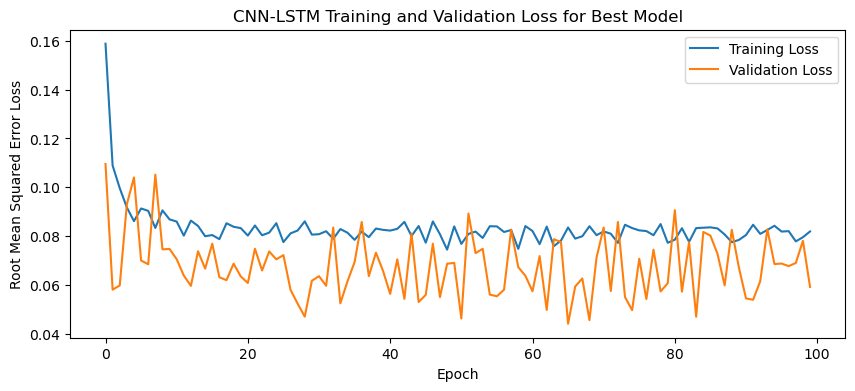

1/1 - 2s - loss: 0.0754 - 2s/epoch - 2s/step
Test Loss: 0.07544419914484024
Fold 2:
Epoch 1/100
19/19 [==============================] - 11s 188ms/step - loss: 0.1528 - val_loss: 0.1015
Epoch 2/100
19/19 [==============================] - 1s 53ms/step - loss: 0.0981 - val_loss: 0.0782
Epoch 3/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0984 - val_loss: 0.0799
Epoch 4/100
19/19 [==============================] - 1s 31ms/step - loss: 0.0817 - val_loss: 0.0798
Epoch 5/100
19/19 [==============================] - 1s 44ms/step - loss: 0.0853 - val_loss: 0.0625
Epoch 6/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0823 - val_loss: 0.0798
Epoch 7/100
19/19 [==============================] - 1s 48ms/step - loss: 0.0840 - val_loss: 0.0983
Epoch 8/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0806 - val_loss: 0.0712
Epoch 9/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0783 - val_loss: 0.0766
Epoch 10/100
1

1/1 - 2s - loss: 0.0958 - 2s/epoch - 2s/step
Test Loss: 0.0958210825920105
Fold 3:
Epoch 1/100
19/19 [==============================] - 11s 158ms/step - loss: 0.1467 - val_loss: 0.1282
Epoch 2/100
19/19 [==============================] - 1s 49ms/step - loss: 0.0965 - val_loss: 0.0941
Epoch 3/100
19/19 [==============================] - 1s 47ms/step - loss: 0.0872 - val_loss: 0.1248
Epoch 4/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0900 - val_loss: 0.1035
Epoch 5/100
19/19 [==============================] - 1s 68ms/step - loss: 0.0880 - val_loss: 0.0928
Epoch 6/100
19/19 [==============================] - 1s 61ms/step - loss: 0.0832 - val_loss: 0.0685
Epoch 7/100
19/19 [==============================] - 2s 99ms/step - loss: 0.0789 - val_loss: 0.1102
Epoch 8/100
19/19 [==============================] - 1s 67ms/step - loss: 0.0799 - val_loss: 0.0719
Epoch 9/100
19/19 [==============================] - 2s 103ms/step - loss: 0.0804 - val_loss: 0.0856
Epoch 10/100
1

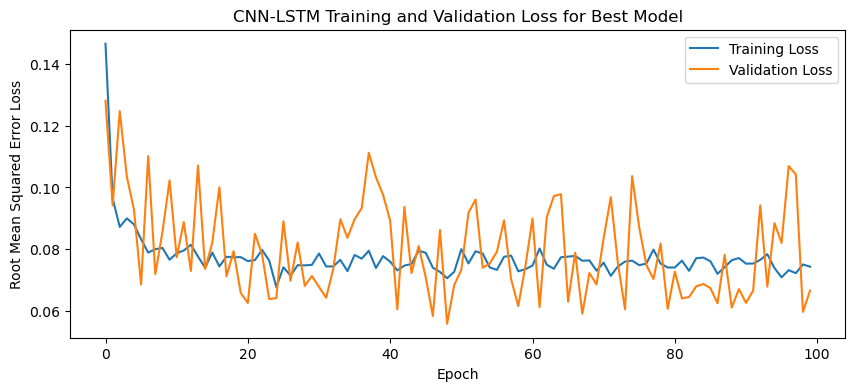

1/1 - 2s - loss: 0.0779 - 2s/epoch - 2s/step
Test Loss: 0.07789324969053268
Fold 4:
Epoch 1/100
20/20 [==============================] - 13s 168ms/step - loss: 0.2050 - val_loss: 0.1726
Epoch 2/100
20/20 [==============================] - 1s 52ms/step - loss: 0.1353 - val_loss: 0.1158
Epoch 3/100
20/20 [==============================] - 1s 51ms/step - loss: 0.1312 - val_loss: 0.1202
Epoch 4/100
20/20 [==============================] - 1s 57ms/step - loss: 0.1301 - val_loss: 0.1086
Epoch 5/100
20/20 [==============================] - 3s 130ms/step - loss: 0.1196 - val_loss: 0.0654
Epoch 6/100
20/20 [==============================] - 3s 138ms/step - loss: 0.1097 - val_loss: 0.0770
Epoch 7/100
20/20 [==============================] - 1s 35ms/step - loss: 0.1089 - val_loss: 0.1099
Epoch 8/100
20/20 [==============================] - 1s 57ms/step - loss: 0.1145 - val_loss: 0.0754
Epoch 9/100
20/20 [==============================] - 2s 100ms/step - loss: 0.1099 - val_loss: 0.0703
Epoch 10/10

1/1 - 2s - loss: 0.1048 - 2s/epoch - 2s/step
Test Loss: 0.10476846992969513
Fold 5:
Epoch 1/100
19/19 [==============================] - 10s 182ms/step - loss: 0.1449 - val_loss: 0.1176
Epoch 2/100
19/19 [==============================] - 1s 35ms/step - loss: 0.1108 - val_loss: 0.0877
Epoch 3/100
19/19 [==============================] - 1s 38ms/step - loss: 0.0921 - val_loss: 0.1065
Epoch 4/100
19/19 [==============================] - 1s 54ms/step - loss: 0.0898 - val_loss: 0.0785
Epoch 5/100
19/19 [==============================] - 1s 59ms/step - loss: 0.0909 - val_loss: 0.0826
Epoch 6/100
19/19 [==============================] - 1s 52ms/step - loss: 0.0886 - val_loss: 0.0996
Epoch 7/100
19/19 [==============================] - 1s 50ms/step - loss: 0.0838 - val_loss: 0.0957
Epoch 8/100
19/19 [==============================] - 1s 61ms/step - loss: 0.0850 - val_loss: 0.0931
Epoch 9/100
19/19 [==============================] - 1s 53ms/step - loss: 0.0836 - val_loss: 0.0805
Epoch 10/100
1

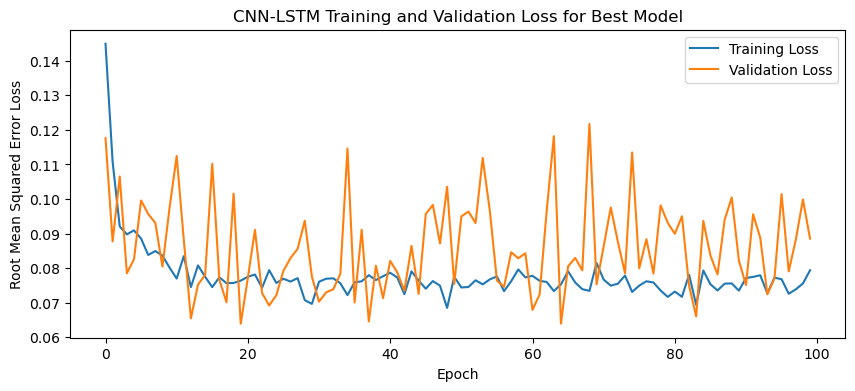

1/1 - 2s - loss: 0.0628 - 2s/epoch - 2s/step
Test Loss: 0.06281660497188568


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

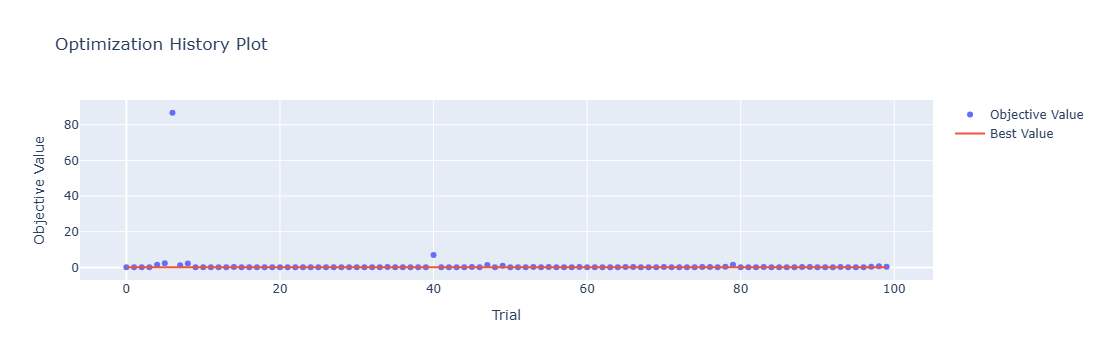

In [4]:
optuna.visualization.plot_optimization_history(study)

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

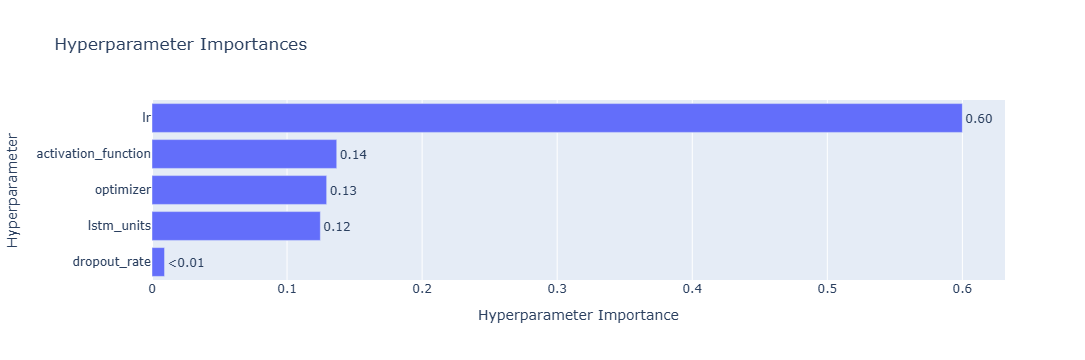

In [6]:
optuna.visualization.plot_param_importances(study)

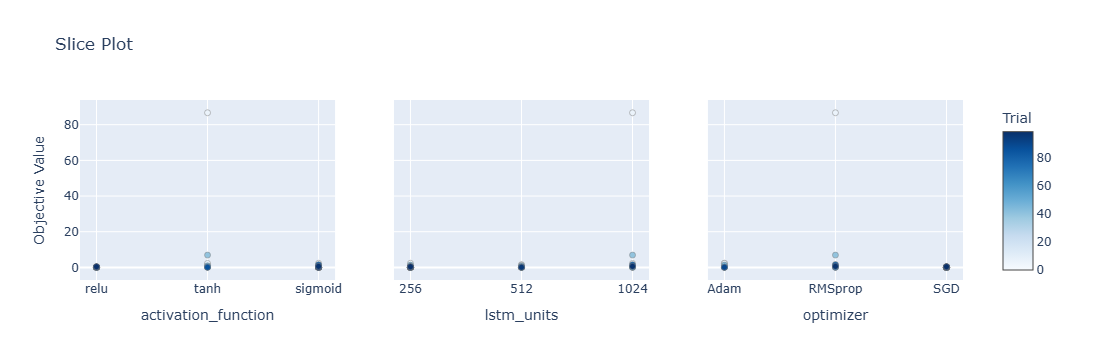

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 5s 73ms/step - loss: 0.1504 - accuracy: 0.3158 - mae: 0.1346 - rmse: 0.1504 - mape: 33.2563 - pearson: 0.1688 - val_loss: 0.0981 - val_accuracy: 0.6667 - val_mae: 0.0859 - val_rmse: 0.0981 - val_mape: 19.8357 - val_pearson: 0.2167
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1020 - accuracy: 0.3158 - mae: 0.0827 - rmse: 0.1020 - mape: 21.5869 - pearson: 0.3254 - val_loss: 0.1175 - val_accuracy: 0.3333 - val_mae: 0.0922 - val_rmse: 0.1175 - val_mape: 23.0315 - val_pearson: 0.3565
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1065 - accuracy: 0.

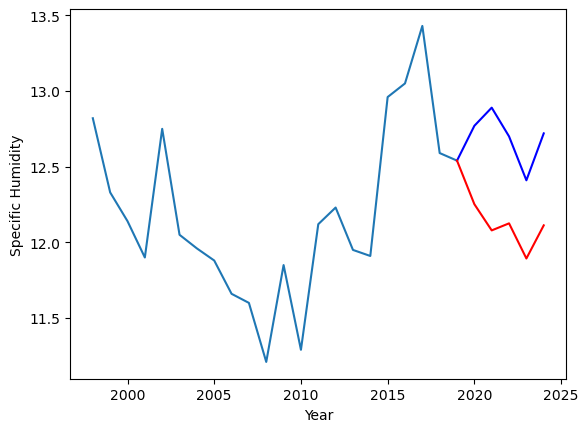

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.88		9.50		-0.38
10.09		9.33		-0.76
9.65		9.38		-0.27
9.13		9.14		0.01
9.32		9.36		0.04


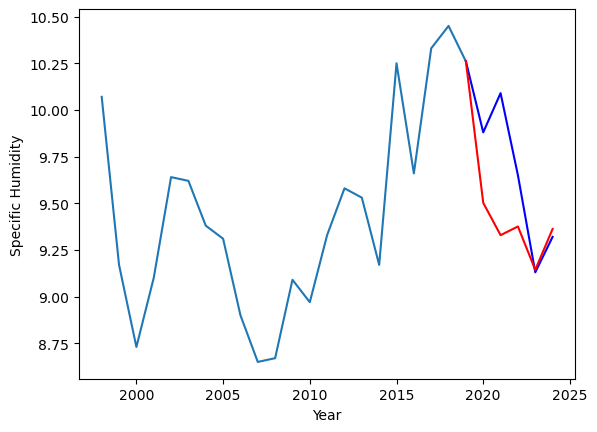

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.77  12.252242
1                1    9.88   9.502242


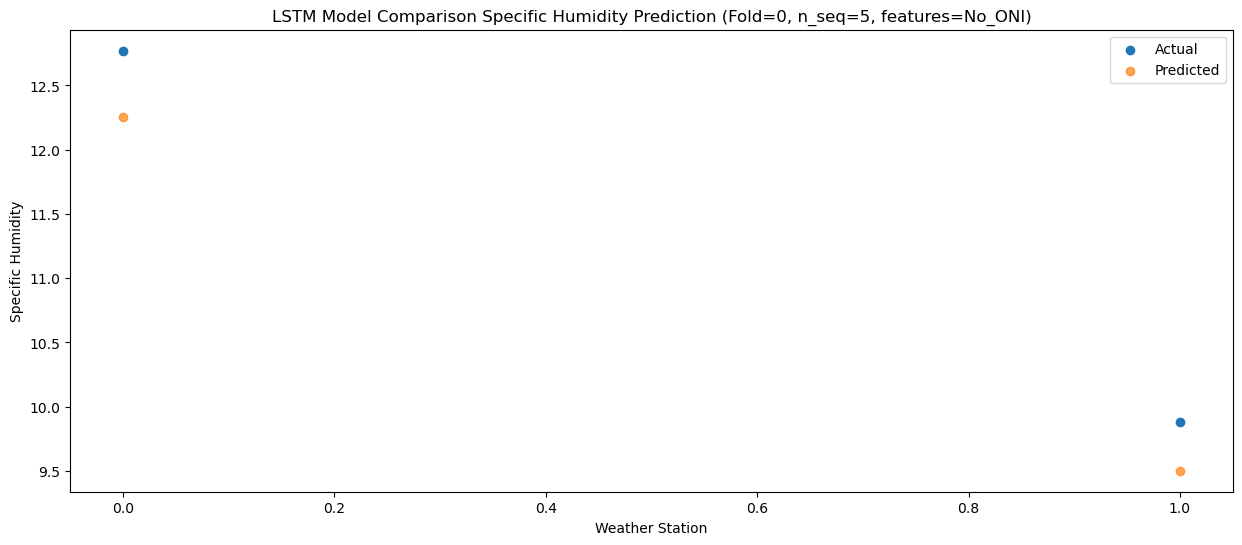

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.89  12.078997
1                1   10.09   9.328997


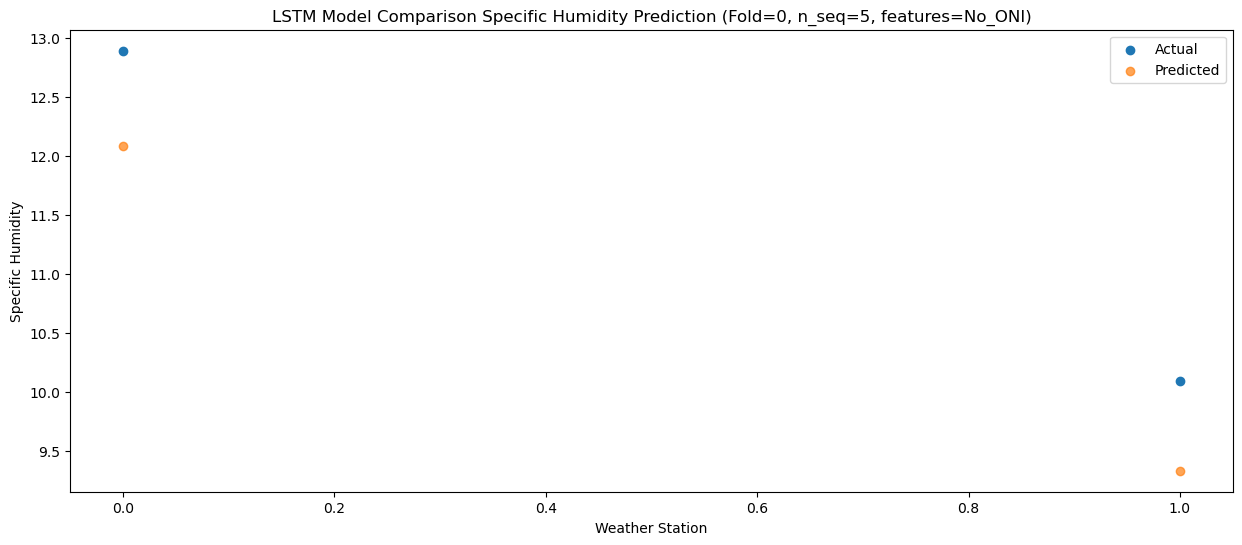

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.70  12.125565
1                1    9.65   9.375565


Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.41  11.893373
1                1    9.13   9.143373


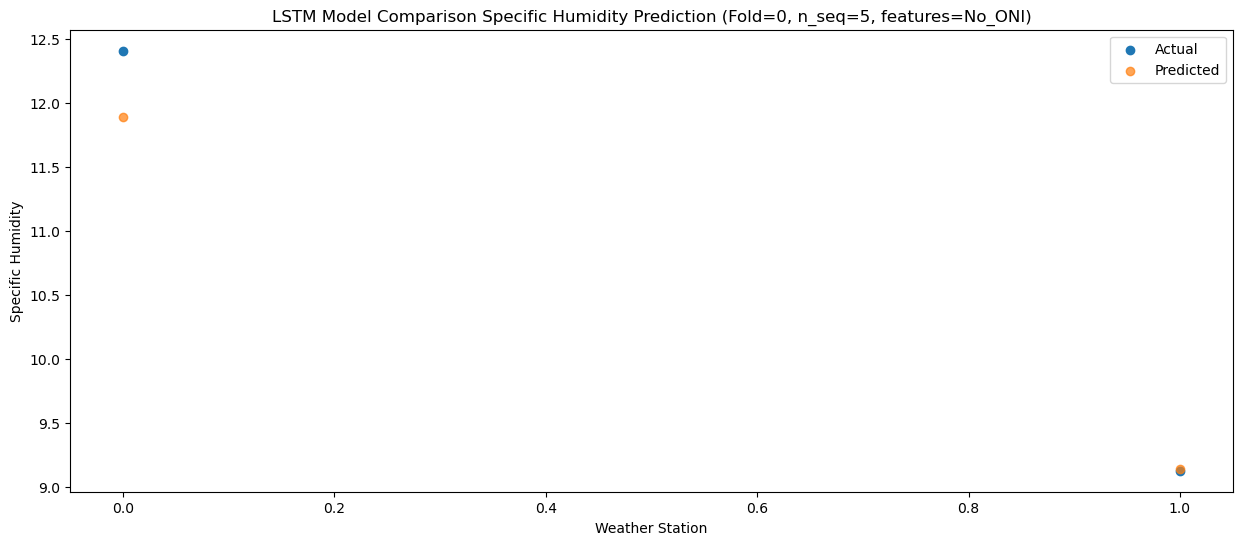

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.72  12.112346
1                1    9.32   9.362346


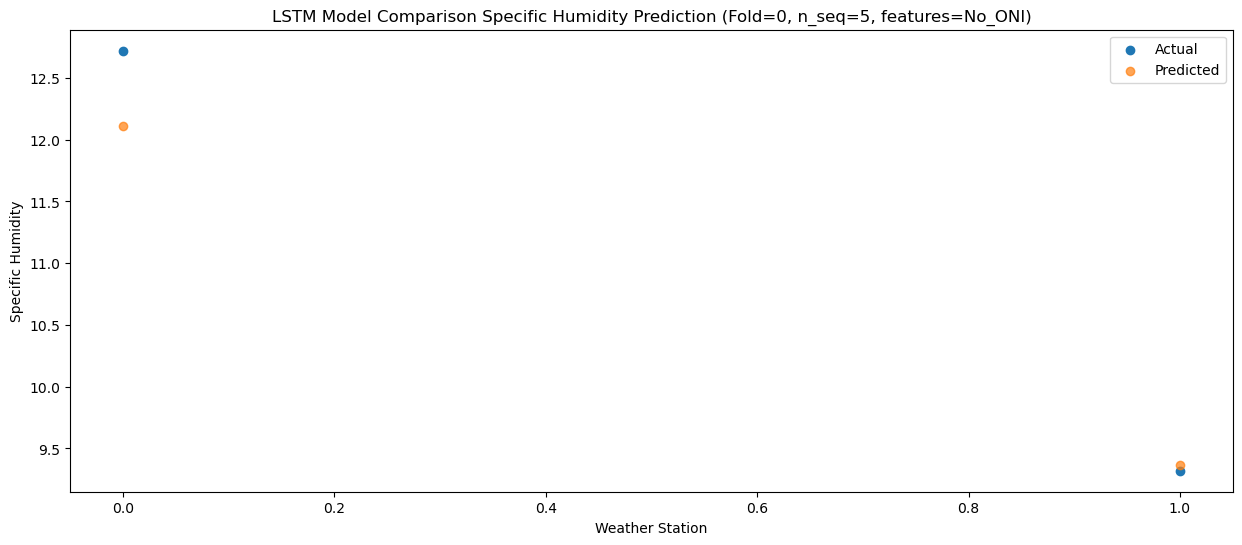

f, t:
[[12.77  9.88]
 [12.89 10.09]
 [12.7   9.65]
 [12.41  9.13]
 [12.72  9.32]]
[[12.25224198  9.50224198]
 [12.07899722  9.32899722]
 [12.12556466  9.37556466]
 [11.89337285  9.14337285]
 [12.11234583  9.36234583]]
Year at t+1:
t+1 SKRMSE: 0.453197
t+1 KRMSE: 0.453197
t+1 MAE: 0.447758
t+1 SKMAPE: 0.039390
t+1 R2_SCORE: 0.901636
t+1 KMAPE: 0.039390
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.325000
Year at t+2:
t+2 SKRMSE: 0.786400
t+2 KRMSE: 0.786400
t+2 MAE: 0.786003
t+2 SKMAPE: 0.069169
t+2 R2_SCORE: 0.684477
t+2 KMAPE: 0.069169
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 11.490000
Year at t+3:
t+3 SKRMSE: 0.450161
t+3 KRMSE: 0.450161
t+3 MAE: 0.424435
t+3 SKMAPE: 0.036835
t+3 R2_SCORE: 0.912864
t+3 KMAPE: 0.036835
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 11.175000
Year at t+4:
t+4 SKRMSE: 0.365433
t+4 KRMSE: 0.365433
t+4 MAE: 0.265000
t+4 SKMAPE: 0.021547
t+4 R2_SCORE: 0.950349
t+4 KMAPE: 0.021547
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 10.770000
Year at t+5:
t+5 SKRMSE: 0.430

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 5s 71ms/step - loss: 0.1436 - accuracy: 0.1579 - mae: 0.1293 - rmse: 0.1436 - mape: 31.0626 - pearson: 0.3291 - val_loss: 0.1282 - val_accuracy: 0.0000e+00 - val_mae: 0.1131 - val_rmse: 0.1282 - val_mape: 26.8079 - val_pearson: 0.1184
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1036 - accuracy: 0.2632 - mae: 0.0870 - rmse: 0.1036 - mape: 20.7956 - pearson: 0.2640 - val_loss: 0.0809 - val_accuracy: 0.3333 - val_mae: 0.0705 - val_rmse: 0.0809 - val_mape: 17.2273 - val_pearson: 0.4371
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.0899 - accuracy

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.66		6.84		-0.82
6.92		6.99		0.07
7.36		7.23		-0.13
6.79		7.05		0.26
6.94		7.25		0.31


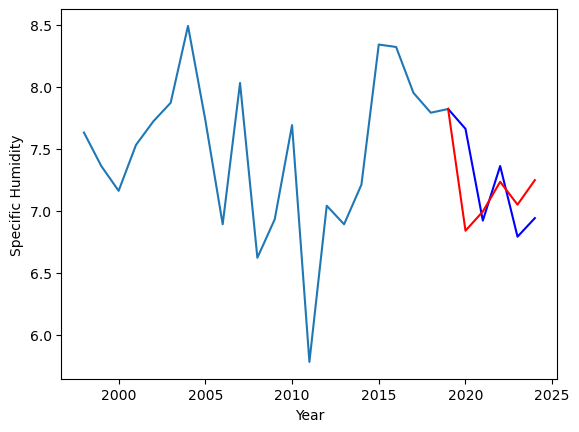

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   10.80  10.678239
1                1    7.66   6.838239


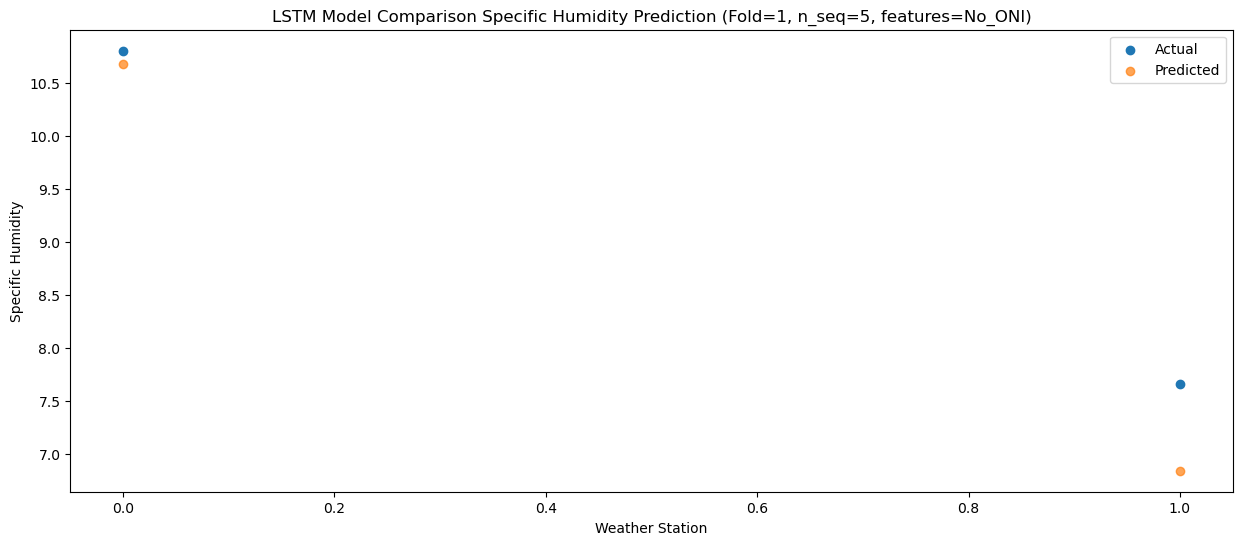

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.16  10.832962
1                1    6.92   6.992962


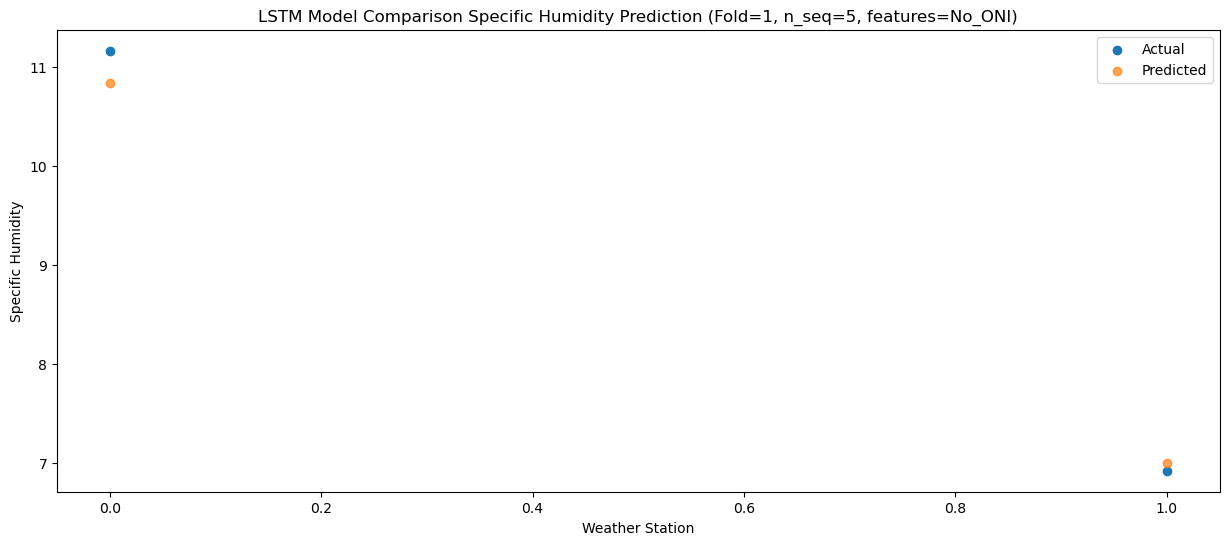

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.49  11.072673
1                1    7.36   7.232673


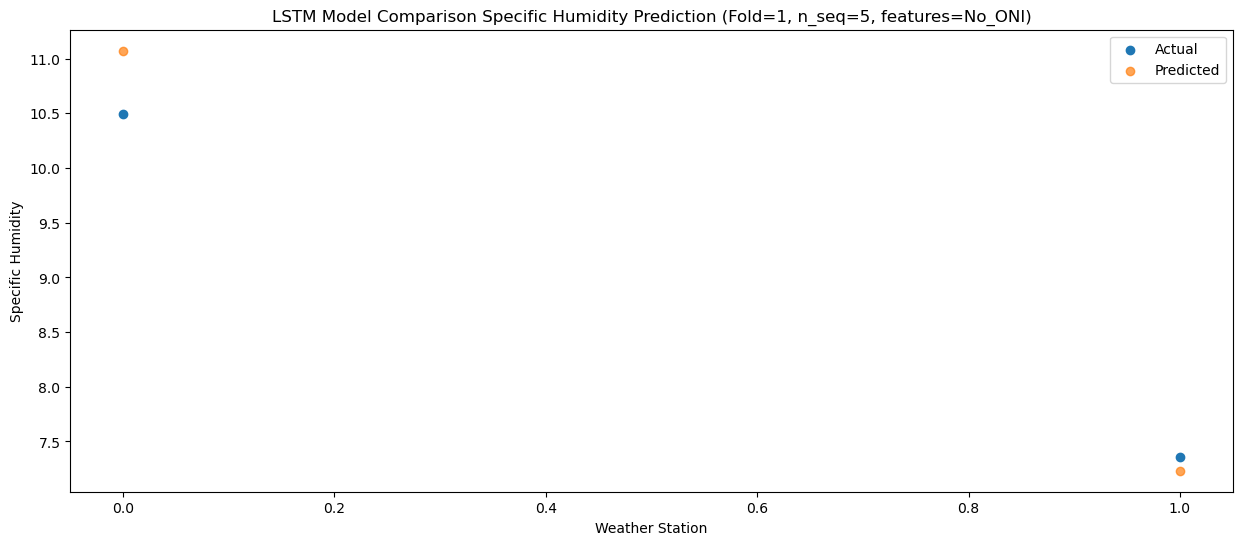

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.54  10.888532
1                1    6.79   7.048532


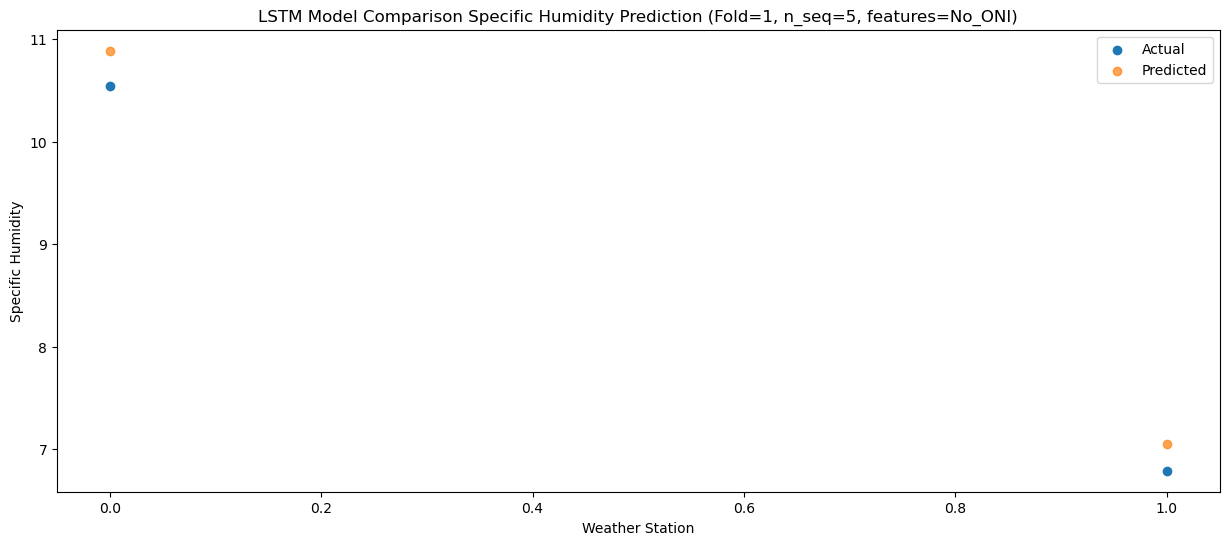

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   10.40  11.086359
1                1    6.94   7.246359


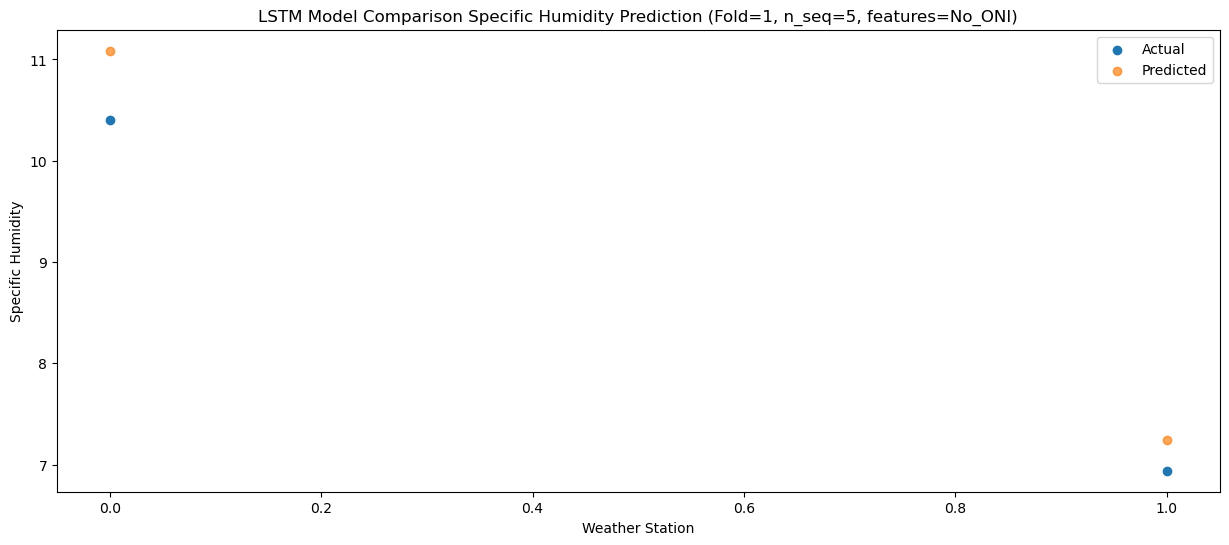

f, t:
[[10.8   7.66]
 [11.16  6.92]
 [10.49  7.36]
 [10.54  6.79]
 [10.4   6.94]]
[[10.67823932  6.83823932]
 [10.83296195  6.99296195]
 [11.07267319  7.23267319]
 [10.88853237  7.04853237]
 [11.0863592   7.2463592 ]]
Year at t+1:
t+1 SKRMSE: 0.587416
t+1 KRMSE: 0.587416
t+1 MAE: 0.471761
t+1 SKMAPE: 0.059277
t+1 R2_SCORE: 0.860011
t+1 KMAPE: 0.059277
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.230000
Year at t+2:
t+2 SKRMSE: 0.236936
t+2 KRMSE: 0.236936
t+2 MAE: 0.200000
t+2 SKMAPE: 0.019924
t+2 R2_SCORE: 0.987509
t+2 KMAPE: 0.019924
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.040000
Year at t+3:
t+3 SKRMSE: 0.421735
t+3 KRMSE: 0.421735
t+3 MAE: 0.355000
t+3 SKMAPE: 0.036423
t+3 R2_SCORE: 0.927381
t+3 KMAPE: 0.036423
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.925000
Year at t+4:
t+4 SKRMSE: 0.306850
t+4 KRMSE: 0.306850
t+4 MAE: 0.303532
t+4 SKMAPE: 0.035572
t+4 R2_SCORE: 0.973218
t+4 KMAPE: 0.035572
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.665000
Year at t+5:
t+5 SKRMSE: 0.531481


[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 5s 79ms/step - loss: 0.1566 - accuracy: 0.2632 - mae: 0.1395 - rmse: 0.1566 - mape: 32.6658 - pearson: 0.2725 - val_loss: 0.1174 - val_accuracy: 0.6667 - val_mae: 0.1055 - val_rmse: 0.1174 - val_mape: 24.6509 - val_pearson: 0.4506
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1034 - accuracy: 0.2632 - mae: 0.0894 - rmse: 0.1034 - mape: 22.4867 - pearson: 0.3628 - val_loss: 0.0778 - val_accuracy: 0.6667 - val_mae: 0.0673 - val_rmse: 0.0778 - val_mape: 15.7199 - val_pearson: 0.7600
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.84		7.97		0.13
7.66		8.22		0.56
7.73		8.54		0.81
8.00		8.01		0.01
8.01		8.30		0.29


Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.64   9.385501
1                1    7.84   7.965501


Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    9.11   9.640868
1                1    7.66   8.220868


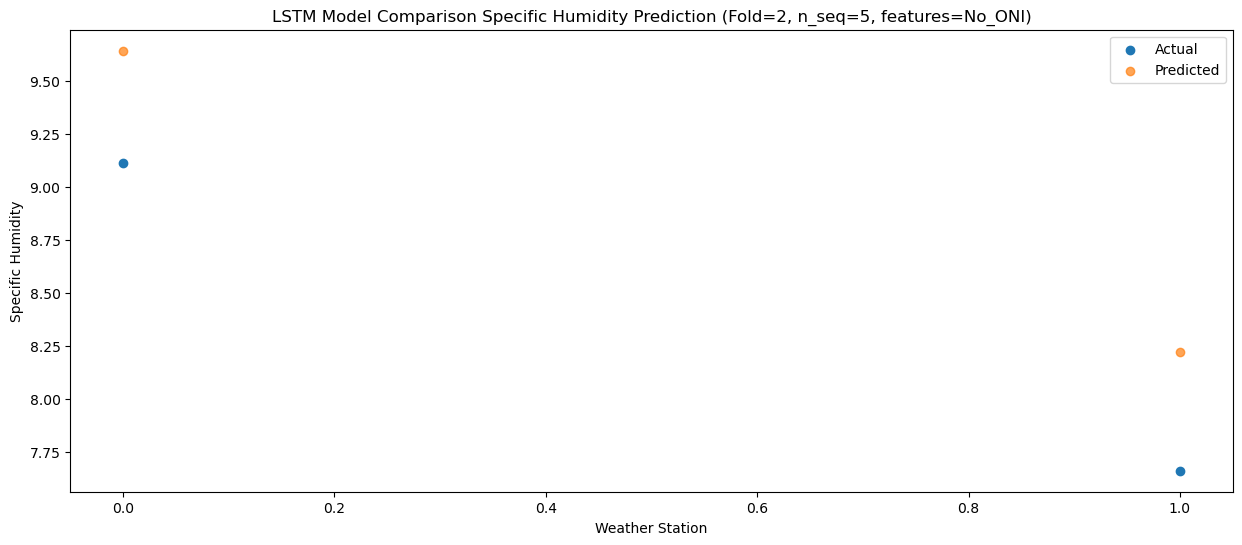

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    8.70   9.956028
1                1    7.73   8.536028


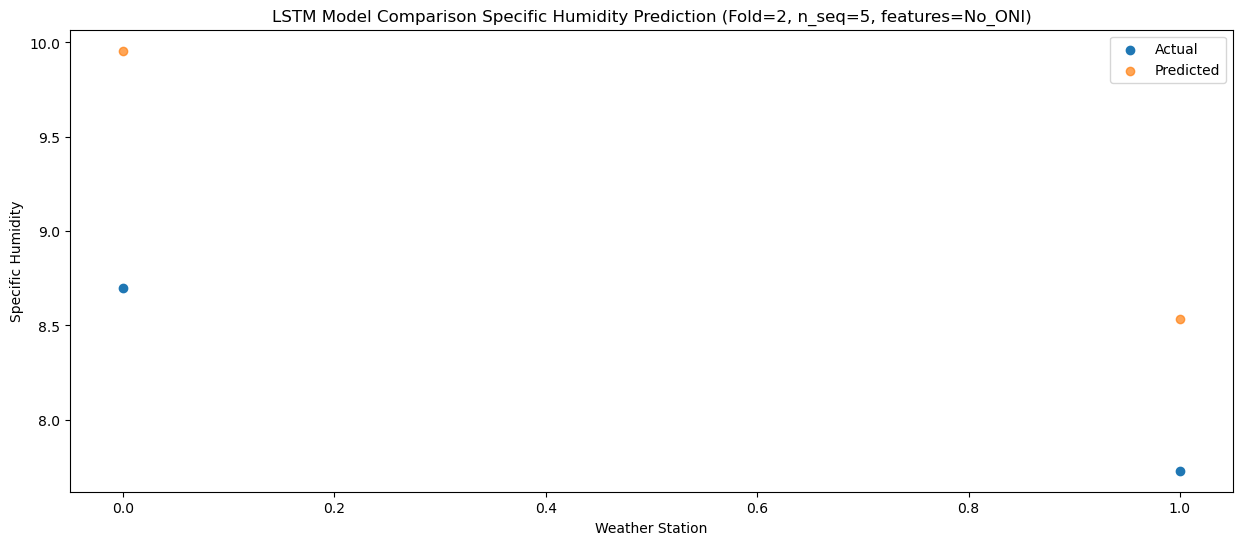

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0     8.6   9.431885
1                1     8.0   8.011885


Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    8.87   9.722784
1                1    8.01   8.302784


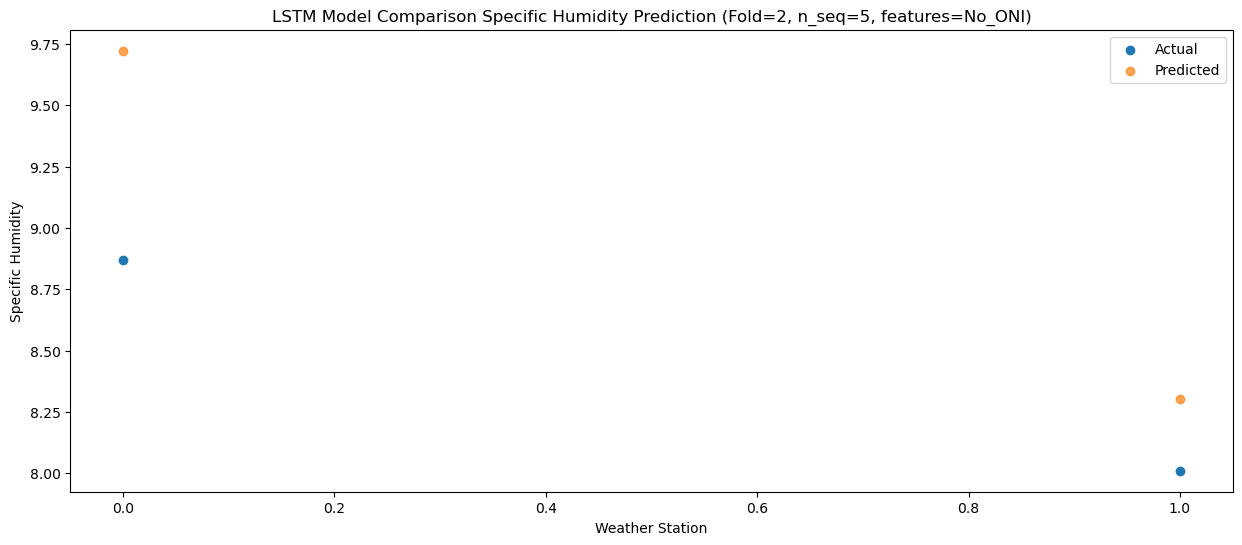

f, t:
[[9.64 7.84]
 [9.11 7.66]
 [8.7  7.73]
 [8.6  8.  ]
 [8.87 8.01]]
[[9.38550124 7.96550124]
 [9.64086813 8.22086813]
 [9.9560279  8.5360279 ]
 [9.43188545 8.01188545]
 [9.72278393 8.30278393]]
Year at t+1:
t+1 SKRMSE: 0.200649
t+1 KRMSE: 0.200649
t+1 MAE: 0.190000
t+1 SKMAPE: 0.021204
t+1 R2_SCORE: 0.950296
t+1 KMAPE: 0.021204
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.740000
Year at t+2:
t+2 SKRMSE: 0.546074
t+2 KRMSE: 0.546074
t+2 MAE: 0.545868
t+2 SKMAPE: 0.065747
t+2 R2_SCORE: 0.432681
t+2 KMAPE: 0.065747
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 8.385000
Year at t+3:
t+3 SKRMSE: 1.055293
t+3 KRMSE: 1.055293
t+3 MAE: 1.031028
t+3 SKMAPE: 0.124322
t+3 R2_SCORE: -3.734376
t+3 KMAPE: 0.124322
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 8.215000
Year at t+4:
t+4 SKRMSE: 0.588292
t+4 KRMSE: 0.588292
t+4 MAE: 0.421885
t+4 SKMAPE: 0.049108
t+4 R2_SCORE: -2.845415
t+4 KMAPE: 0.049108
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.300000
Year at t+5:
t+5 SKRMSE: 0.637559
t+5 KRMSE: 0.63755

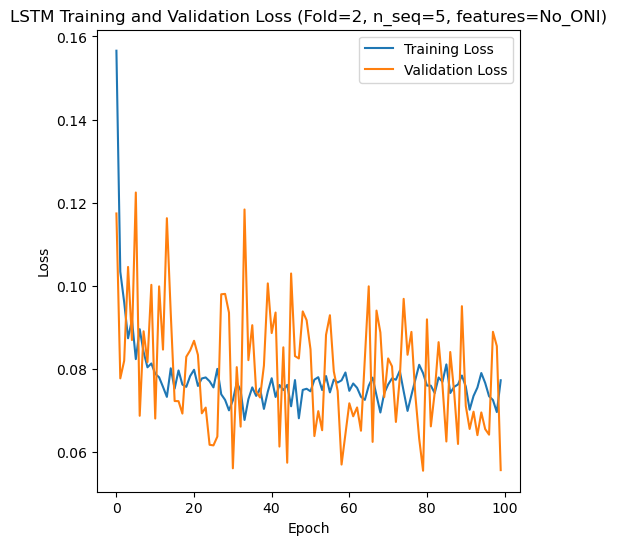

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 5s 81ms/step - loss: 0.2044 - accuracy: 0.2000 - mae: 0.1852 - rmse: 0.2044 - mape: 32.7757 - pearson: 0.3248 - val_loss: 0.1213 - val_accuracy: 0.0000e+00 - val_mae: 0.1150 - val_rmse: 0.1213 - val_mape: 19.5157 - val_pearson: 0.1821
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1351 - accuracy: 0.3000 - mae: 0.1097 - rmse: 0.1351 - mape: 20.2800 - pearson: 0.3352 - val_loss: 0.1011 - val_accuracy: 0.0000e+00 - val_mae: 0.0903 - val_rmse: 0.1011 - val_mape: 16.1417 - val_pearson: 0.2460
Epoch 3/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.3000 - mae: 0.1030 - rmse: 0.1252 - mape: 18.8136 

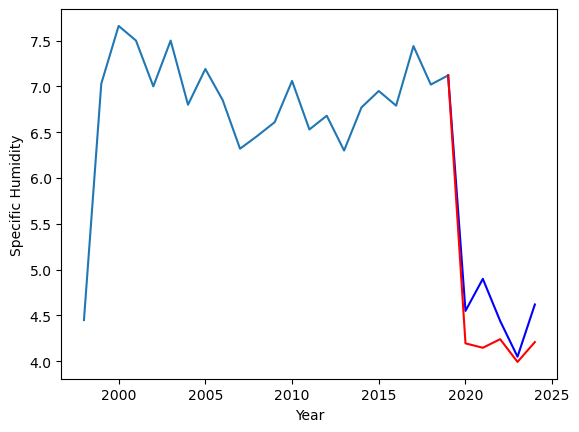

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.21		8.08		-0.13
8.12		8.03		-0.09
8.09		8.12		0.03
7.62		7.87		0.25
7.64		8.09		0.45


Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.55   4.195723
1                1    8.21   8.075723


Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    4.90   4.147744
1                1    8.12   8.027744


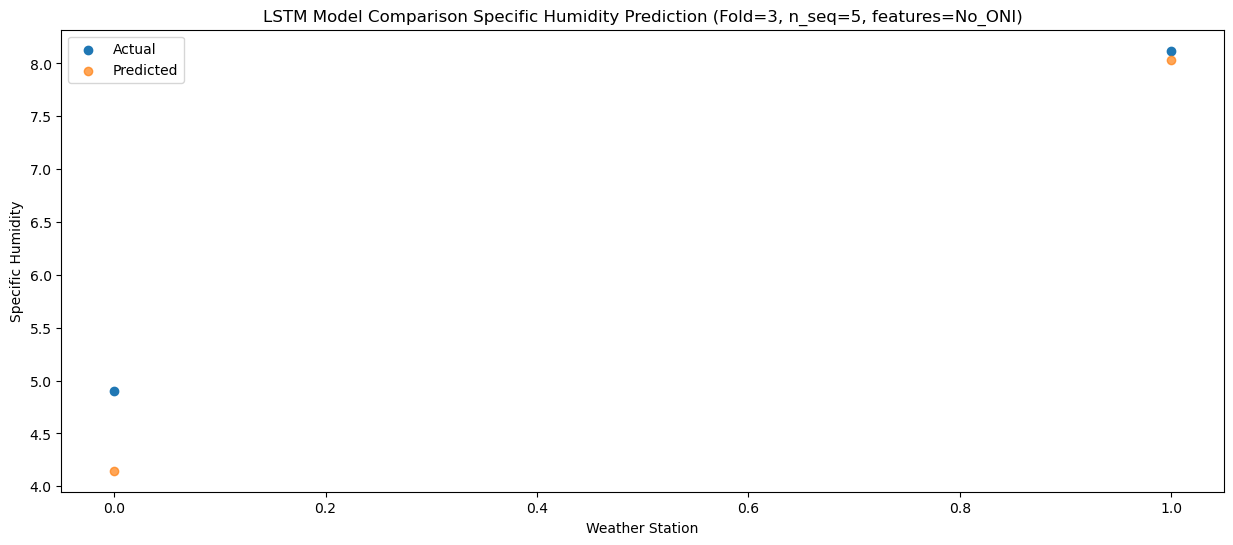

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.44   4.241319
1                1    8.09   8.121319


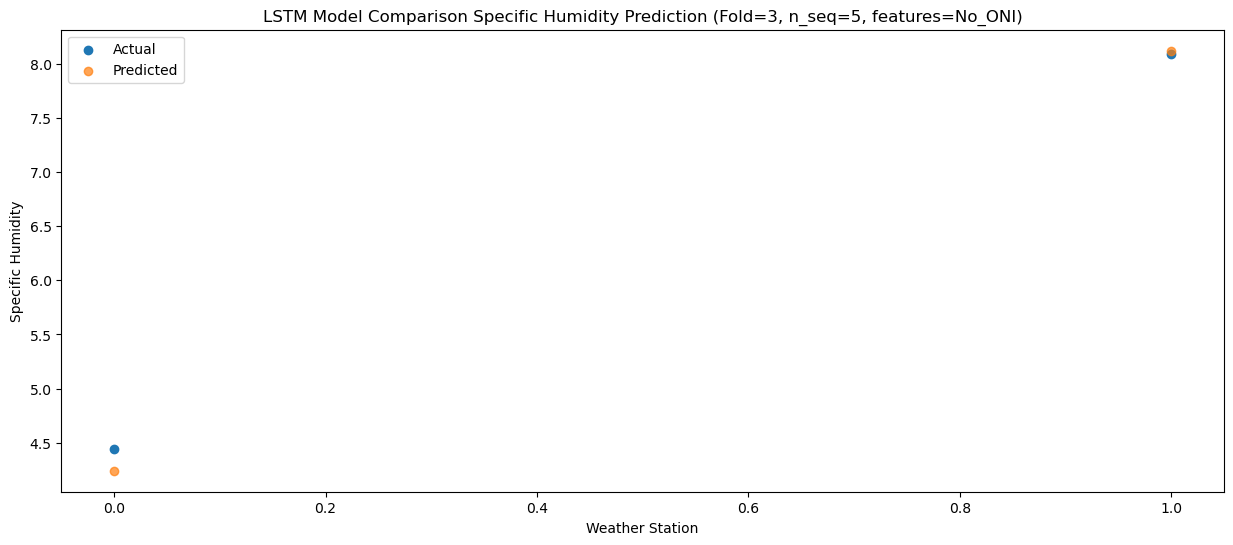

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    4.05   3.993272
1                1    7.62   7.873272


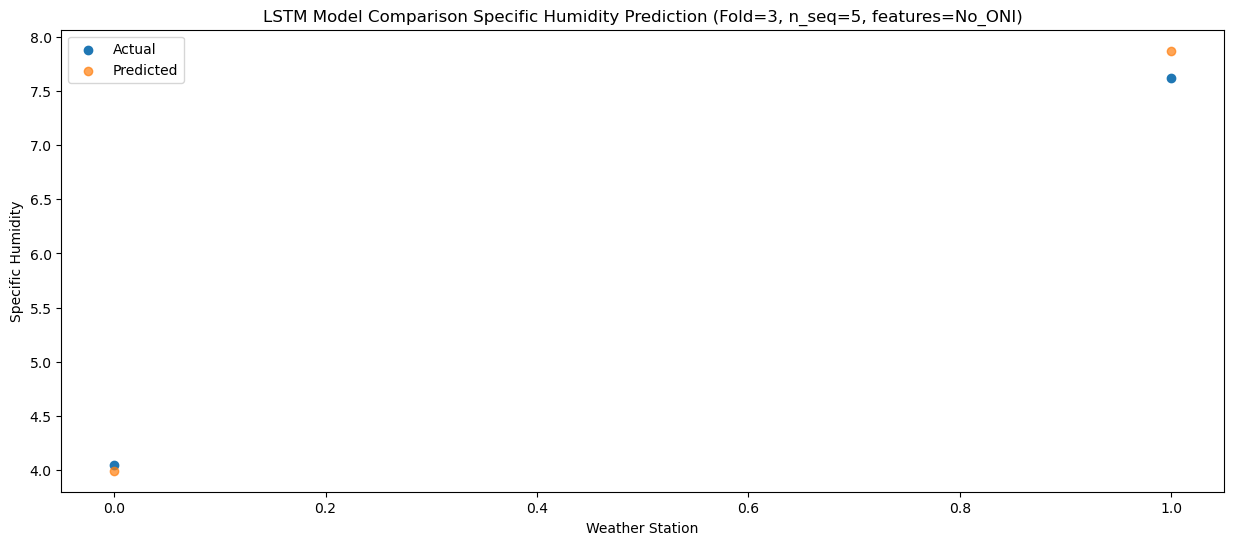

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    4.62   4.210042
1                1    7.64   8.090042


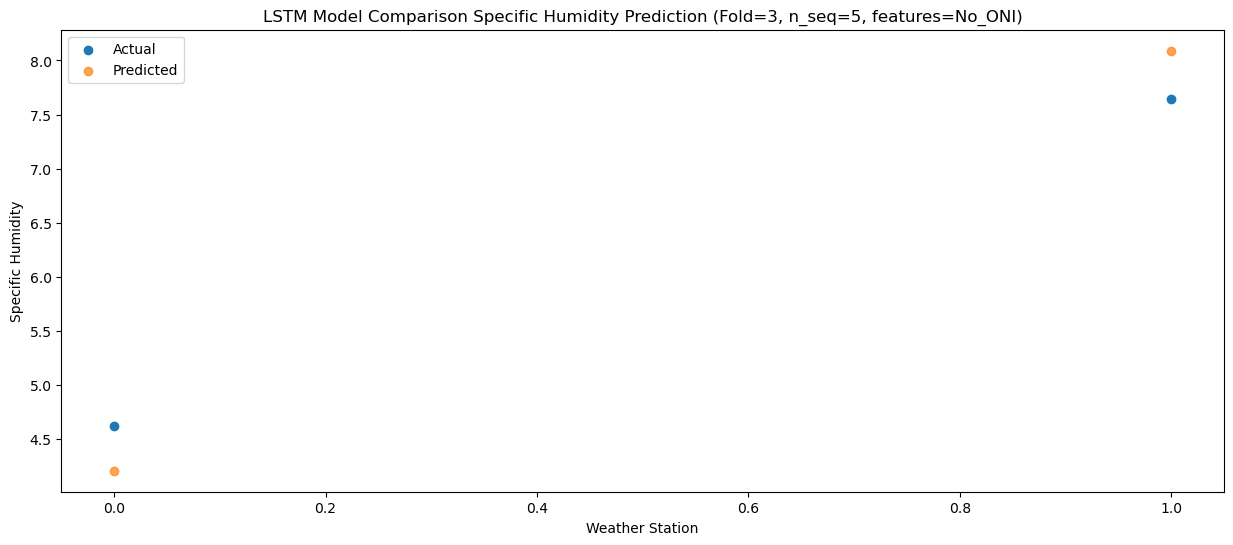

f, t:
[[4.55 8.21]
 [4.9  8.12]
 [4.44 8.09]
 [4.05 7.62]
 [4.62 7.64]]
[[4.19572349 8.07572349]
 [4.14774441 8.02774441]
 [4.24131916 8.12131916]
 [3.99327156 7.87327156]
 [4.21004191 8.09004191]]
Year at t+1:
t+1 SKRMSE: 0.267901
t+1 KRMSE: 0.267901
t+1 MAE: 0.244277
t+1 SKMAPE: 0.047109
t+1 R2_SCORE: 0.978569
t+1 KMAPE: 0.047109
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.380000
Year at t+2:
t+2 SKRMSE: 0.535910
t+2 KRMSE: 0.535910
t+2 MAE: 0.422256
t+2 SKMAPE: 0.082442
t+2 R2_SCORE: 0.889202
t+2 KMAPE: 0.082442
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.510000
Year at t+3:
t+3 SKRMSE: 0.142223
t+3 KRMSE: 0.142223
t+3 MAE: 0.115000
t+3 SKMAPE: 0.024310
t+3 R2_SCORE: 0.993927
t+3 KMAPE: 0.024310
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.265000
Year at t+4:
t+4 SKRMSE: 0.183527
t+4 KRMSE: 0.183527
t+4 MAE: 0.155000
t+4 SKMAPE: 0.023622
t+4 R2_SCORE: 0.989429
t+4 KMAPE: 0.023622
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 5.835000
Year at t+5:
t+5 SKRMSE: 0.430467
t+5 KRMSE: 0.430467


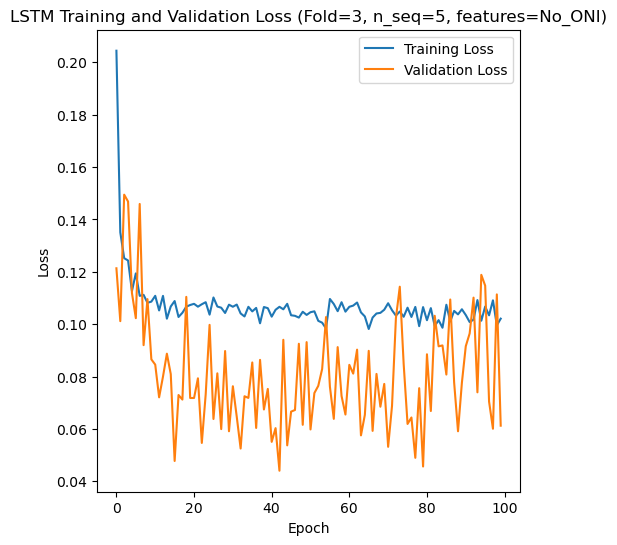

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 6s 91ms/step - loss: 0.1533 - accuracy: 0.2632 - mae: 0.1356 - rmse: 0.1533 - mape: 32.6248 - pearson: 0.2758 - val_loss: 0.1213 - val_accuracy: 0.0000e+00 - val_mae: 0.1002 - val_rmse: 0.1213 - val_mape: 25.7938 - val_pearson: 0.4731
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1164 - accuracy: 0.3158 - mae: 0.0992 - rmse: 0.1164 - mape: 24.2489 - pearson: 0.3076 - val_loss: 0.1066 - val_accuracy: 0.0000e+00 - val_mae: 0.0903 - val_rmse: 0.1066 - val_mape: 21.0641 - val_pearson: 0.2432
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1050 - accur

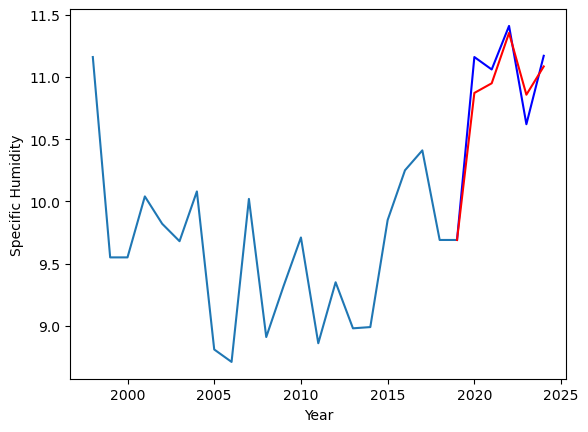

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.79		8.04		0.25
7.52		8.12		0.60
7.85		8.52		0.67
7.25		8.03		0.78
7.48		8.25		0.77


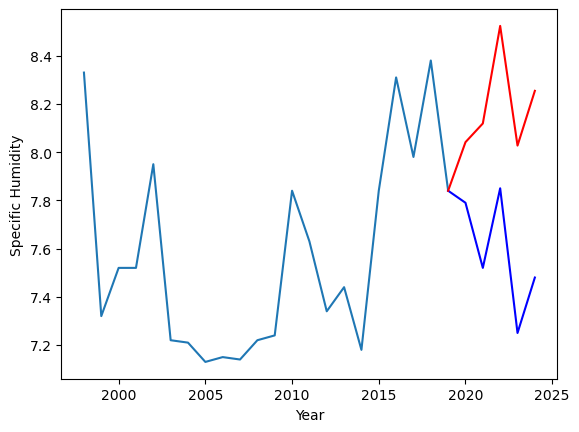

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.16  10.871455
1                1    7.79   8.041455


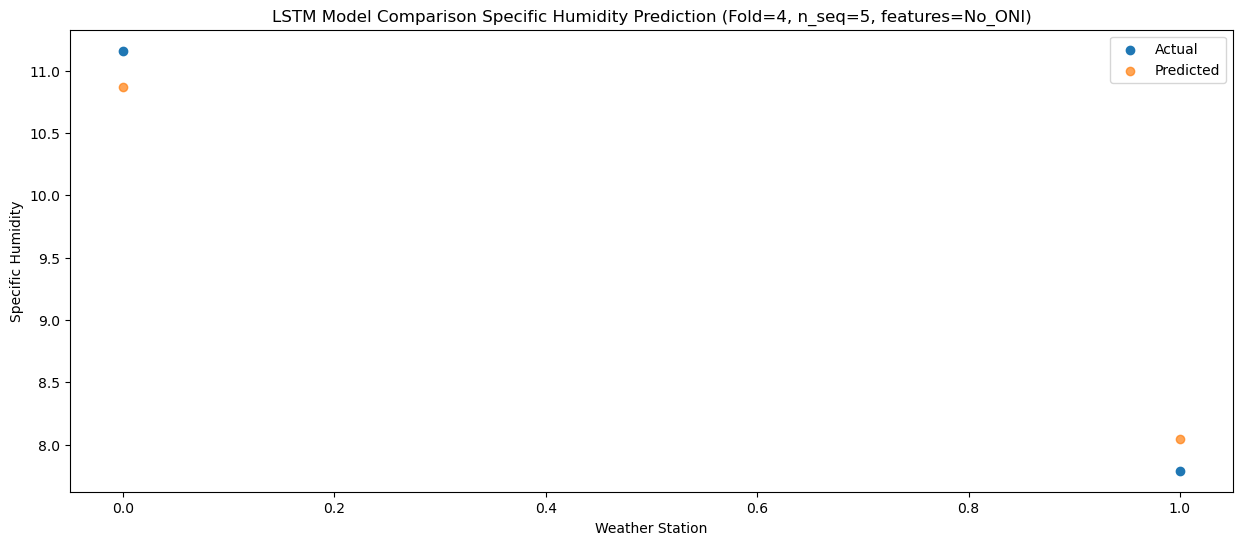

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   11.06  10.948945
1                1    7.52   8.118945


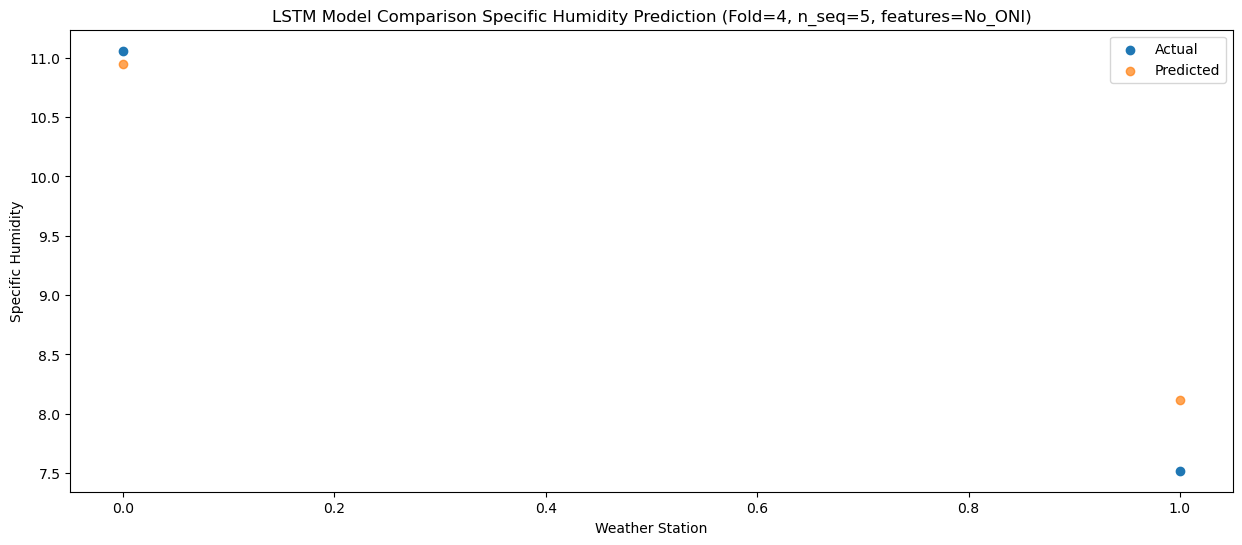

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.41  11.353515
1                1    7.85   8.523515


Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.62  10.857213
1                1    7.25   8.027213


Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.17  11.084294
1                1    7.48   8.254294


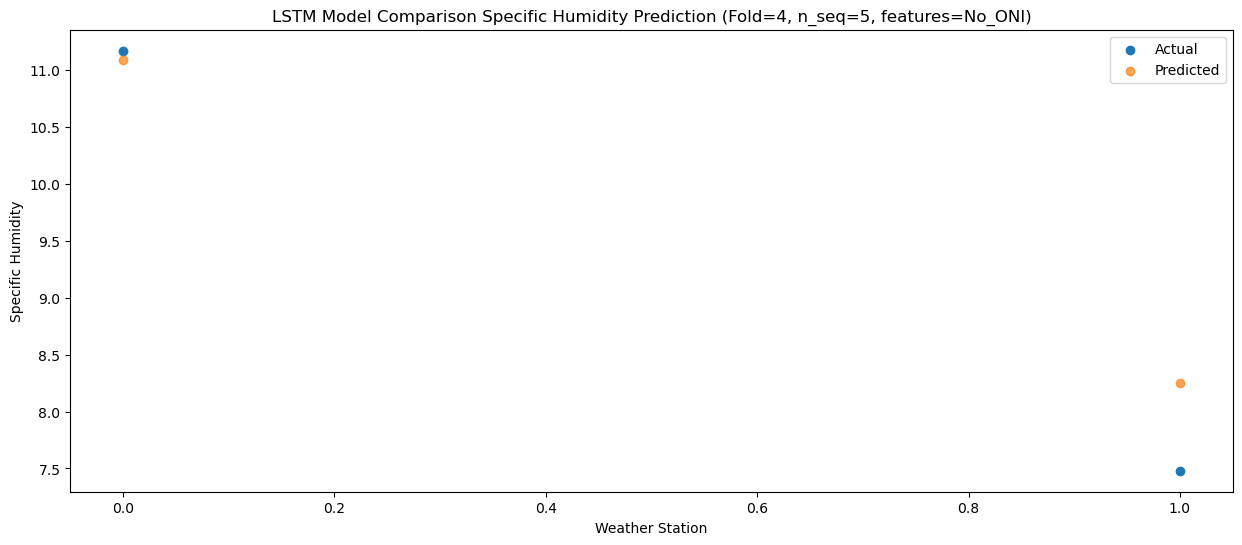

f, t:
[[11.16  7.79]
 [11.06  7.52]
 [11.41  7.85]
 [10.62  7.25]
 [11.17  7.48]]
[[10.87145475  8.04145475]
 [10.94894453  8.11894453]
 [11.35351526  8.52351526]
 [10.85721289  8.02721289]
 [11.08429379  8.25429379]]
Year at t+1:
t+1 SKRMSE: 0.270636
t+1 KRMSE: 0.270636
t+1 MAE: 0.270000
t+1 SKMAPE: 0.029067
t+1 R2_SCORE: 0.974203
t+1 KMAPE: 0.029067
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.475000
Year at t+2:
t+2 SKRMSE: 0.430737
t+2 KRMSE: 0.430737
t+2 MAE: 0.355000
t+2 SKMAPE: 0.044844
t+2 R2_SCORE: 0.940779
t+2 KMAPE: 0.044844
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.290000
Year at t+3:
t+3 SKRMSE: 0.477919
t+3 KRMSE: 0.477919
t+3 MAE: 0.365000
t+3 SKMAPE: 0.045374
t+3 R2_SCORE: 0.927911
t+3 KMAPE: 0.045374
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.630000
Year at t+4:
t+4 SKRMSE: 0.574600
t+4 KRMSE: 0.574600
t+4 MAE: 0.507213
t+4 SKMAPE: 0.064769
t+4 R2_SCORE: 0.883713
t+4 KMAPE: 0.064769
t+4 PEARSON: 1.000000
t+4 AVERAGE ACTUAL: 8.935000
Year at t+5:
t+5 SKRMSE: 0.550852


[[0.5187518830503501], [0.437192463163436], [0.6640285232025465], [0.345885025586451], [0.47345277460182184]]
[[array(0.51875188)], [array(0.43719246)], [array(0.66402852)], [array(0.34588503)], [array(0.47345277)]]
[[0.44963922852277777], [0.3653304517269135], [0.5523130822181703], [0.27330641996860516], [0.38544257795810727]]
[[0.038619792563451355], [0.041253024462455726], [0.06534566581717796], [0.050260684883794836], [0.04792974362968091]]
[[0.8902623408729783], [0.9408394731972672], [-0.09897184522001545], [0.9601369156556413], [0.9283953625845153]]
[[array(0.03861979)], [array(0.04125302)], [array(0.06534567)], [array(0.05026068)], [array(0.04792974)]]
[[array(0.98057122)], [array(0.95228083)], [array(0.65565937)], [array(0.98232152)], [array(0.98810369)]]
[12.77 12.89 12.7  12.41 12.72  9.88 10.09  9.65  9.13  9.32 10.8  11.16
 10.49 10.54 10.4   7.66  6.92  7.36  6.79  6.94  9.64  9.11  8.7   8.6
  8.87  7.84  7.66  7.73  8.    8.01  4.55  4.9   4.44  4.05  4.62  8.21
  8.12  

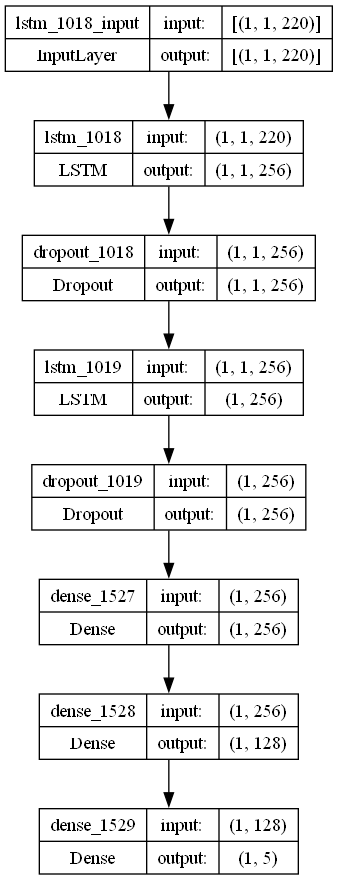

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.23784980743911982
    optimizer = SGD(learning_rate = lr)
    activation_function = 'relu'
    lstm_units = 256
    dropout_rate = 0.40883350723944606

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S5_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)